# Parallel Coordinates Plots

##### source: https://reedgroup.github.io/FigureLibrary/ParallelCoordinatesPlots.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler

In [2]:
figsize = (18,6)
fontsize = 14
main_data_dir = "../output/metrics/"
data_dir_knobs = "../data/parallelplots/"
fig_dir = '../output/parallelplots/'

##### Functions for flexible parallel coordinates plots

In [3]:
### function to normalize data based on direction of preference and whether each objective is minimized or maximized
###   -> output dataframe will have values ranging from 0 (which maps to bottom of figure) to 1 (which maps to top)
def reorganize_objs(objs, columns_axes, ideal_direction, minmaxs):
    ### if min/max directions not given for each axis, assume all should be maximized
    if minmaxs is None:
        minmaxs = ['max']*len(columns_axes)

    ### get subset of dataframe columns that will be shown as parallel axes
    objs_reorg = objs[columns_axes]

    ### reorganize & normalize data to go from 0 (bottom of figure) to 1 (top of figure), 
    ### based on direction of preference for figure and individual axes
    if ideal_direction == 'bottom':
        tops = objs_reorg.min(axis=0)
        bottoms = objs_reorg.max(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, -1] = (objs_reorg.iloc[:, -1] - objs_reorg.iloc[:, -1].min(axis=0)) / \
                                         (objs_reorg.iloc[:, -1].max(axis=0) - objs_reorg.iloc[:, -1].min(axis=0))
    elif ideal_direction == 'top':
        tops = objs_reorg.max(axis=0)
        bottoms = objs_reorg.min(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i] - objs_reorg.iloc[:, i].min(axis=0)) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))

    return objs_reorg, tops, bottoms

In [4]:
### function to get color based on continuous color map or categorical map
def get_color(value, color_by_continuous, color_palette_continuous,
              color_by_categorical, color_dict_categorical):
    if color_by_continuous is not None:
        color = plt.get_cmap(color_palette_continuous)(value)
    elif color_by_categorical is not None:
        color = color_dict_categorical[value]
    return color

In [5]:
### function to get zorder value for ordering lines on plot. 
### This works by binning a given axis' values and mapping to discrete classes.
def get_zorder(norm_value, zorder_num_classes, zorder_direction):
    xgrid = np.arange(0, 1.001, 1/zorder_num_classes)
    if zorder_direction == 'ascending':
        return 4 + np.sum(norm_value > xgrid)
    elif zorder_direction == 'descending':
        return 4 + np.sum(norm_value < xgrid)

In [6]:
### customizable parallel coordinates plot
## COLUMN AXES???
def custom_parallel_coordinates(objs, columns_axes=None, axis_labels=None, ideal_direction='top', minmaxs=None, color_by_continuous=None, color_palette_continuous=None, color_by_categorical=None, color_palette_categorical=None, colorbar_ticks_continuous=None, color_dict_categorical=None, zorder_by=None, zorder_num_classes=10, zorder_direction='ascending', alpha_base=0.8, brushing_dict=None, alpha_brush=0.05, lw_base=1.5, fontsize=14, figsize=(11,6), save_fig_filename=None):
    """
    Parameters:
    objs (DataFrame): The DataFrame containing the data to plot.
    columns_axes (list, optional): List of column names to use as axes. Defaults to all columns.
    axis_labels (list, optional): List of axis labels. Defaults to the same as columns_axes.
    ideal_direction (str, optional): Direction of preference for objective values. Can be 'top' or 'bottom'. Defaults to 'top'.
    minmaxs (list, optional): List of 'max' or 'min' for each column, indicating if higher or lower values are better.
    color_by_continuous (str, optional): Column name to color lines by continuous values. Cannot be used with color_by_categorical.
    color_palette_continuous (Colormap, optional): Colormap to use for continuous coloring.
    color_by_categorical (str, optional): Column name to color lines by categorical values. Cannot be used with color_by_continuous.
    color_palette_categorical (list, optional): List of colors to use for categorical coloring.
    colorbar_ticks_continuous (list, optional): List of tick values for the continuous colorbar.
    color_dict_categorical (dict, optional): Dictionary mapping categorical values to colors.
    zorder_by (str, optional): Column name to determine the z-order (layer) of the lines.
    zorder_num_classes (int, optional): Number of classes for z-ordering. Defaults to 10.
    zorder_direction (str, optional): Direction for z-ordering. Can be 'ascending' or 'descending'. Defaults to 'ascending'.
    alpha_base (float, optional): Base alpha (transparency) value for the lines. Defaults to 0.8.
    brushing_dict (dict, optional): Dictionary specifying brushing criteria in the form {column_index: (threshold, operator)}.
    alpha_brush (float, optional): Alpha value for lines that do not meet brushing criteria. Defaults to 0.05.
    lw_base (float, optional): Baseline width for the lines. Defaults to 1.5.
    fontsize (int, optional): Font size for the labels and annotations. Defaults to 14.
    figsize (tuple, optional): Size of the figure in inches. Defaults to (11, 6).
    save_fig_filename (str, optional): Filename to save the figure. If None, the figure is not saved. Defaults to None.
    """

    ### verify that all inputs take supported values
    assert ideal_direction in ['top','bottom']
    assert zorder_direction in ['ascending', 'descending']
    if minmaxs is not None:
        for minmax in minmaxs:
            assert minmax in ['max','min']
    assert color_by_continuous is None or color_by_categorical is None
    if columns_axes is None:
        columns_axes = objs.columns
    if axis_labels is None:
        #axis_labels = columns_axes ## <--- column_axes is not defined? Ask about this (Axis labels have to be defined)
        axis_labels = columns_axes

    ### create figure
    fig,ax = plt.subplots(1,1,figsize=figsize, gridspec_kw={'hspace':0.1, 'wspace':0.1})

    ### reorganize & normalize objective data
    objs_reorg, tops, bottoms = reorganize_objs(objs, columns_axes, ideal_direction, minmaxs)

    ### apply any brushing criteria
    if brushing_dict is not None:
        satisfice = np.zeros(objs.shape[0]) == 0.
        ### iteratively apply all brushing criteria to get satisficing set of solutions
        for col_idx, (threshold, operator) in brushing_dict.items():
            if operator == '<':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] < threshold)
            elif operator == '<=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] <= threshold)
            elif operator == '>':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] > threshold)
            elif operator == '>=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] >= threshold)

            ### add rectangle patch to plot to represent brushing
            threshold_norm = (threshold - bottoms[col_idx]) / (tops[col_idx] - bottoms[col_idx])
            if ideal_direction == 'top' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
            elif ideal_direction == 'top' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            if ideal_direction == 'bottom' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            elif ideal_direction == 'bottom' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)

            pc = PatchCollection([rect], facecolor='grey', alpha=0.5, zorder=3)
            ax.add_collection(pc)

    ### loop over all solutions/rows & plot on parallel axis plot
    for i in range(objs_reorg.shape[0]):
        if color_by_continuous is not None:
            color = get_color(objs_reorg[columns_axes[color_by_continuous]].iloc[i],
                              color_by_continuous, color_palette_continuous,
                              color_by_categorical, color_dict_categorical)
        elif color_by_categorical is not None:
            color = get_color(objs[color_by_categorical].iloc[i],
                              color_by_continuous, color_palette_continuous,
                              color_by_categorical, color_dict_categorical)

        ### order lines according to ascending or descending values of one of the objectives?
        if zorder_by is None:
            zorder = 4
        else:
            zorder = get_zorder(objs_reorg[columns_axes[zorder_by]].iloc[i],
                                zorder_num_classes, zorder_direction)

        ### apply any brushing?
        if brushing_dict is not None:
            if satisfice.iloc[i]:
                alpha = alpha_base
                lw = lw_base
            else:
                alpha = alpha_brush
                lw = 1
                zorder = 2
        else:
            alpha = alpha_base
            lw = lw_base

        ## loop over objective/column pairs & plot lines between parallel axes
        for j in range(objs_reorg.shape[1]-1):
            y = [objs_reorg.iloc[i, j], objs_reorg.iloc[i, j+1]]
            x = [j, j+1]
            ax.plot(x, y, c=color, alpha=alpha, zorder=zorder, lw=lw)

    ### add top/bottom ranges
    for j in range(len(columns_axes)):
        ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom',
                    zorder=5, fontsize=fontsize)
        if j == len(columns_axes)-1:
            ax.annotate(str(round(bottoms[j])) + '+', [j, -0.02], ha='center', va='top',
                        zorder=5, fontsize=fontsize)
        else:
            ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top',
                        zorder=5, fontsize=fontsize)

        ax.plot([j,j], [0,1], c='k', zorder=1)

    ### other aesthetics
    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_visible(False)

    if ideal_direction == 'top':
        ax.arrow(-0.15,0.1,0,0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    elif ideal_direction == 'bottom':
        ax.arrow(-0.15,0.9,0,-0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    ax.annotate('Direction of preference', xy=(-0.3,0.5), ha='center', va='center',
                rotation=90, fontsize=fontsize)

    #ax.set_xlim(-0.4, 4.2) # REASON WHY ONLY 5 VARS
    ax.set_xlim(-0.4, len(columns_axes) - 0.6)
    ax.set_ylim(-0.4,1.1)

    for i,l in enumerate(axis_labels):
        ax.annotate(l, xy=(i,-0.12), ha='center', va='top', fontsize=fontsize)
    ax.patch.set_alpha(0)


    ### colorbar for continuous legend
    if color_by_continuous is not None:
        mappable = cm.ScalarMappable(cmap=color_palette_continuous)
        mappable.set_clim(vmin=objs[columns_axes[color_by_continuous]].min(),
                          vmax=objs[columns_axes[color_by_continuous]].max())
        cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,
                          label=axis_labels[color_by_continuous], pad=0.03,
                          alpha=alpha_base)
        if colorbar_ticks_continuous is not None:
            _ = cb.ax.set_xticks(colorbar_ticks_continuous, colorbar_ticks_continuous,
                                 fontsize=fontsize)
        _ = cb.ax.set_xlabel(cb.ax.get_xlabel(), fontsize=fontsize)
        ### categorical legend
    elif color_by_categorical is not None:
        leg = []
        for label,color in color_dict_categorical.items():
            leg.append(Line2D([0], [0], color=color, lw=3,
                              alpha=alpha_base, label=label))
        _ = ax.legend(handles=leg, loc='lower center',
                      ncol=max(3, len(color_dict_categorical)),
                      bbox_to_anchor=[0.5,-0.07], frameon=False, fontsize=fontsize)

    ### save figure
    if save_fig_filename is not None:
        plt.savefig(save_fig_filename, bbox_inches='tight', transparent=True, dpi=600)

In [7]:
def custom_parallel_coordinates_highlight_cluster(objs, columns_axes=None, axis_labels=None, ideal_direction='top', minmaxs=None, color_by_continuous=None, color_palette_continuous=None, color_by_categorical=None, color_palette_categorical=None, colorbar_ticks_continuous=None, color_dict_categorical=None, zorder_by=None, zorder_num_classes=10, zorder_direction='ascending', alpha_base=0.8, brushing_dict=None, alpha_brush=0.05, lw_base=1.5, fontsize=14, figsize=(11,6), save_fig_filename=None, cluster_column_name='Cluster', title=None, highlight_indices=None, highlight_colors=None):
    assert ideal_direction in ['top','bottom']
    assert zorder_direction in ['ascending', 'descending']
    if minmaxs is not None:
        for minmax in minmaxs:
            assert minmax in ['max','min']
    assert color_by_continuous is None or color_by_categorical is None
    if columns_axes is None:
        columns_axes = objs.columns
    if axis_labels is None:
        axis_labels = columns_axes

    fig, ax = plt.subplots(1, 1, figsize=figsize, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

    objs_reorg, tops, bottoms = reorganize_objs(objs, columns_axes, ideal_direction, minmaxs)

    if brushing_dict is not None:
        satisfice = np.zeros(objs.shape[0]) == 0.
        for col_idx, (threshold, operator) in brushing_dict.items():
            if operator == '<':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] < threshold)
            elif operator == '<=':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] <= threshold)
            elif operator == '>':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] > threshold)
            elif operator == '>=':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] >= threshold)

            threshold_norm = (threshold - bottoms[col_idx]) / (tops[col_idx] - bottoms[col_idx])
            rect = Rectangle([col_idx - 0.05, 0], 0.1, threshold_norm)
            pc = PatchCollection([rect], facecolor='grey', alpha=0.5, zorder=3)
            ax.add_collection(pc)

    # Ensure baseline and highlight colors and labels
    baseline_present = 0 in objs.index
    highlight_labels = [f"median {i+1}" for i in range(len(highlight_indices))]
    highlight_colors = highlight_colors

    if baseline_present:
        highlight_indices = [0] + highlight_indices
        highlight_labels = ["baseline"] + highlight_labels
        highlight_colors = ["black"] + highlight_colors

    for i in range(objs_reorg.shape[0]):
        idx_value = objs.index[i]
        if idx_value == 0 and baseline_present:
            color = "black"
            zorder = 20  # Bring to the very front
            lw = 4  # Make line wider
            label = "baseline"
        elif idx_value in highlight_indices:
            color = highlight_colors[highlight_indices.index(idx_value)]
            zorder = 15  # Bring to the front
            lw = 4  # Make line wider
            label = highlight_labels[highlight_indices.index(idx_value)]
        elif color_by_categorical is not None and cluster_column_name in objs.columns:
            cluster_value = objs[cluster_column_name].iloc[i]
            color = color_dict_categorical.get(cluster_value, 'grey')  # Use color_dict_categorical for color
            zorder = 4
            lw = lw_base
            label = None
        else:
            color = color_dict_categorical[1]  # Fallback color if no cluster info
            zorder = 4
            lw = lw_base
            label = None

        alpha = alpha_base

        for j in range(objs_reorg.shape[1] - 1):
            y = [objs_reorg.iloc[i, j], objs_reorg.iloc[i, j + 1]]
            x = [j, j + 1]
            ax.plot(x, y, c=color, alpha=alpha, zorder=zorder, lw=lw)

    for j in range(len(columns_axes)):
        ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom', zorder=5, fontsize=fontsize)
        ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top', zorder=5, fontsize=fontsize)
        ax.plot([j, j], [0, 1], c='k', zorder=1)

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

    if ideal_direction == 'top':
        ax.arrow(-0.15, 0.1, 0, 0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    elif ideal_direction == 'bottom':
        ax.arrow(-0.15, 0.9, 0, -0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    ax.annotate('Direction of preference', xy=(-0.3, 0.5), ha='center', va='center', rotation=90, fontsize=fontsize)

    ax.set_xlim(-0.4, len(columns_axes) - 0.6)
    ax.set_ylim(-0.4, 1.1)

    for i, l in enumerate(axis_labels):
        ax.annotate(l, xy=(i, -0.12), ha='center', va='top', fontsize=fontsize)

    if color_by_continuous is not None:
        mappable = cm.ScalarMappable(cmap=color_palette_continuous)
        mappable.set_clim(vmin=objs[columns_axes[color_by_continuous]].min(),
                          vmax=objs[columns_axes[color_by_continuous]].max())
        cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,
                          label=axis_labels[color_by_continuous], pad=0.03,
                          alpha=alpha_base)
        if colorbar_ticks_continuous is not None:
            _ = cb.ax.set_xticks(colorbar_ticks_continuous, colorbar_ticks_continuous,
                                 fontsize=fontsize)
        _ = cb.ax.set_xlabel(cb.ax.get_xlabel(), fontsize=fontsize)
    elif color_by_categorical is not None or highlight_indices is not None:
        leg = []
        if color_by_categorical is not None:
            for label, color in color_dict_categorical.items():
                leg.append(Line2D([0], [0], color=color, lw=3, alpha=alpha_base, label=label))
        if highlight_indices is not None:
            for idx, color, label in zip(highlight_indices, highlight_colors, highlight_labels):
                leg.append(Line2D([0], [0], color=color, lw=3, alpha=alpha_base, label=label))

        _ = ax.legend(handles=leg, loc='lower center', ncol=max(3, len(color_dict_categorical)),
                      bbox_to_anchor=[0.5, -0.07], frameon=False, fontsize=fontsize)

    if title is not None:
        ax.set_title(title, fontsize=fontsize)

    if save_fig_filename is not None:
        plt.savefig(save_fig_filename, bbox_inches='tight', transparent=True, dpi=600)

In [8]:
median_colors = ["#DC143C", "#FF8C00", "#4169E1"]
#median_colors = ["green", "pink", "purple"]
color_dict_categorical = {1: 'firebrick', 2: 'goldenrod', 3: 'cornflowerblue'}
color_dict_categorical_1 = {1: 'firebrick'}
color_dict_categorical_2 = {1: 'goldenrod'}
color_dict_categorical_3 = {1: 'cornflowerblue'}

### Kmedoid - July 16 Data
##### Note: Using the 12 variables with clusters generated from kmedoids for the previous 7 filtered variables

In [9]:
# df_clusters = pd.read_csv(data_dir_knobs + "filtered_metrics_07_01_2024_catknobs_idx3.csv")['Cluster']
# wet_df_clusters = pd.read_csv(data_dir_knobs + "filtered_wet_metrics_07_01_2024_catknobs_idx3.csv")['Cluster']
# dry_df_clusters = pd.read_csv(data_dir_knobs + "filtered_dry_metrics_07_01_2024_catknobs_idx3.csv")['Cluster']

In [10]:
df_clusters_new = pd.read_csv(data_dir_knobs + "filtered_metrics_07_01_2024_catknobs_KmedIdx3.csv")['Cluster']
wet_df_clusters_new = pd.read_csv(data_dir_knobs + "filtered_wet_metrics_07_01_2024_catknobs_KmedIdx3.csv")['Cluster']
dry_df_clusters_new = pd.read_csv(data_dir_knobs + "filtered_dry_metrics_07_01_2024_catknobs_KmedIdx3.csv")['Cluster']

In [11]:
# df_716 = pd.read_csv(main_data_dir + "filtered_metrics_07_16_2024.csv").drop(["Unnamed: 0", "Ann_Avg_CVPAgUnmet"], axis = 1).iloc[:, 6:]
# wet_df_716 = pd.read_csv(main_data_dir + "filtered_wet_metrics_07_16_2024.csv").drop(["Unnamed: 0"], axis = 1).iloc[:, 6:]
# dry_df_716 = pd.read_csv(main_data_dir + "filtered_dry_metrics_07_16_2024.csv").drop(["Unnamed: 0"], axis = 1).iloc[:, 6:]

In [12]:
# dry_df_716["Dry_Equity"] = pd.read_csv(data_dir_knobs + "20240605DRAFT_summary_metrics_dry.csv")["Equity"]
# wet_df_716["Wet_Equity"] = pd.read_csv(data_dir_knobs + "20240605DRAFT_summary_metrics_wet.csv")["Equity"]

In [13]:
# df_716["Cluster"] = df_clusters_new
# dry_df_716["Cluster"] = dry_df_clusters_new
# wet_df_716["Cluster"] = wet_df_clusters_new

In [14]:
# df_716.to_csv("df_07_16_24.csv", index = False)
# wet_df_716.to_csv("wet_df_07_16_24.csv", index = False)
# dry_df_716.to_csv("dry_df_07_16_24.csv", index = False)

In [15]:
# df_716_g1 = df_716[["Ann_Avg_SWPTotDel_TAF", "Ann_Avg_SWPMIDel_TAF", "Ann_Avg_CVPTotDel_TAF", "Ann_Avg_CVPAgDel_TAF", "Ann_Avg_CVPSCEXDel_TAF", "Ann_Avg_BanksJones_TAF", "Cluster"]]
# df_716_g2 = df_716[["Apr_Avg_ShstaStorage_TAF", "Apr_Avg_OrovlStorage_TAF", "Fall_Avg_X2_KM", "Spring_Avg_X2_KM", "Ann_Avg_NDO_TAF", "Equity", "Cluster"]]

In [16]:
# wet_716_g1 = wet_df_716[["Wet_Ann_Avg_SWPTotDel_TAF", "Wet_Ann_Avg_SWPMIDel_TAF", "Wet_Ann_Avg_CVPTotDel_TAF", "Wet_Ann_Avg_CVPAgDel_TAF", "Wet_Ann_Avg_CVPSCEXDel_TAF", "Wet_Ann_Avg_BanksJones_TAF", "Cluster"]]
# 
# wet_716_g2 = wet_df_716[["Wet_Apr_Avg_ShstaStorage_TAF", "Wet_Apr_Avg_OrovlStorage_TAF", "Wet_Fall_Avg_X2_KM", "Wet_Spring_Avg_X2_KM", "Wet_Ann_Avg_NDO_TAF", "Wet_Equity", "Cluster"]]

In [17]:
# dry_716_g1 = dry_df_716[["Dry_Ann_Avg_SWPTotDel_TAF", "Dry_Ann_Avg_SWPMIDel_TAF", "Dry_Ann_Avg_CVPTotDel_TAF", "Dry_Ann_Avg_CVPAgDel_TAF", "Dry_Ann_Avg_CVPSCEXDel_TAF", "Dry_Ann_Avg_BanksJones_TAF", "Cluster"]]
# 
# dry_716_g2 = dry_df_716[["Dry_Apr_Avg_ShstaStorage_TAF", "Dry_Apr_Avg_OrovlStorage_TAF", "Dry_Fall_Avg_X2_KM", "Dry_Spring_Avg_X2_KM", "Dry_Ann_Avg_NDO_TAF", "Dry_Equity", "Cluster"]]

In [18]:
# df_716_g1.columns = ["SWPTotDel", "SWPMIDel", "CVPTotDel", "CVPAgDel", "CVPSCEXDel", "BanksJones", "Cluster"]
# wet_716_g1.columns = ["SWPTotDel", "SWPMIDel", "CVPTotDel", "CVPAgDel", "CVPSCEXDel", "BanksJones", "Cluster"]
# dry_716_g1.columns = ["SWPTotDel", "SWPMIDel", "CVPTotDel", "CVPAgDel", "CVPSCEXDel", "BanksJones", "Cluster"]
# 
# df_716_g2.columns = ["ShastaStorage", "OrovilleStorage", "FallX2", "SpringX2", "NDO", "Equity", "Cluster"]
# wet_716_g2.columns = ["ShastaStorage", "OrovilleStorage", "FallX2", "SpringX2", "NDO", "Equity", "Cluster"]
# dry_716_g2.columns = ["ShastaStorage", "OrovilleStorage", "FallX2", "SpringX2", "NDO", "Equity", "Cluster"]

In [19]:
df_knobs = pd.read_csv(data_dir_knobs + "AllMedoidsStudyKnobs.csv")
wet_knobs = pd.read_csv(data_dir_knobs + "WetMedoidsStudyKnobs.csv")
dry_knobs = pd.read_csv(data_dir_knobs + "DryMedoidsStudyKnobs.csv")

In [20]:
all_medoids = df_knobs["Study"].tolist()
wet_medoids = wet_knobs["Study"].tolist()
dry_medoids = dry_knobs["Study"].tolist()

In [21]:
# custom_parallel_coordinates_highlight_cluster(df_716_g1, columns_axes=df_716_g1.columns,
#                                               axis_labels = df_716_g1.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
#                                               save_fig_filename = f'{fig_dir}/df_all_deliveries.png', title="All Years All Clusters Deliveries", highlight_indices = all_medoids, highlight_colors = median_colors) 

In [22]:
# custom_parallel_coordinates_highlight_cluster(df_716_g2, columns_axes=df_716_g2.columns,
#                                               axis_labels = df_716_g2.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
#                                               save_fig_filename = f'{fig_dir}/df_all_rest.png', title="All Years All Clusters Rest of Variables",
#                                               highlight_indices = all_medoids, highlight_colors = median_colors)

In [23]:
# custom_parallel_coordinates_highlight_cluster(wet_716_g1, columns_axes=wet_716_g1.columns,
#                                                 axis_labels = wet_716_g1.columns,
#                                                 zorder_by=4, ideal_direction='top',
#                                                 alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                                 minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                                 color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
#                                                 save_fig_filename = f'{fig_dir}/df_wet_deliveries.png', title="Wet Years All Clusters Deliveries", 
#                                                 highlight_indices = wet_medoids, highlight_colors = median_colors)

In [24]:
# custom_parallel_coordinates_highlight_cluster(wet_716_g2, columns_axes=wet_716_g2.columns,
#                                                 axis_labels = wet_716_g2.columns,
#                                                 zorder_by=4, ideal_direction='top',
#                                                 alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                                 minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                                 color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
#                                                 save_fig_filename = f'{fig_dir}/df_wet_rest.png', title="Wet Years All Clusters Rest of Variables", 
#                                                 highlight_indices = wet_medoids, highlight_colors = median_colors)

In [25]:
# custom_parallel_coordinates_highlight_cluster(dry_716_g1, columns_axes=dry_716_g1.columns,
#                                                 axis_labels = dry_716_g1.columns,
#                                                 zorder_by=4, ideal_direction='top',
#                                                 alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                                 minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                                 color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
#                                                 save_fig_filename = f'{fig_dir}/df_dry_deliveries.png', title="Dry Years All Clusters Deliveries", 
#                                                 highlight_indices = dry_medoids, highlight_colors = median_colors)

In [26]:
# custom_parallel_coordinates_highlight_cluster(dry_716_g2, columns_axes=dry_716_g2.columns,
#                                                 axis_labels = dry_716_g2.columns,
#                                                 zorder_by=4, ideal_direction='top',
#                                                 alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                                 minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                                 color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
#                                                 save_fig_filename = f'{fig_dir}/df_dry_rest.png', title="Dry Years All Clusters Rest of Variables", 
#                                                 highlight_indices = dry_medoids, highlight_colors = median_colors)

### Separate Clusters

In [27]:
# df_716_g1_1 = df_716_g1[(df_716_g1["Cluster"] == 1)].drop("Cluster", axis = 1)
# df_716_g1_2 = df_716_g1[(df_716_g1["Cluster"] == 2)].drop("Cluster", axis = 1)
# df_716_g1_3 = df_716_g1[(df_716_g1["Cluster"] == 3)].drop("Cluster", axis = 1)
# 
# df_716_g2_1 = df_716_g2[(df_716_g2["Cluster"] == 1)].drop("Cluster", axis = 1)
# df_716_g2_2 = df_716_g2[(df_716_g2["Cluster"] == 2)].drop("Cluster", axis = 1)
# df_716_g2_3 = df_716_g2[(df_716_g2["Cluster"] == 3)].drop("Cluster", axis = 1)
# 
# wet_716_g1_1 = wet_716_g1[(wet_716_g1["Cluster"] == 1)].drop("Cluster", axis = 1)
# wet_716_g1_2 = wet_716_g1[(wet_716_g1["Cluster"] == 2)].drop("Cluster", axis = 1)
# wet_716_g1_3 = wet_716_g1[(wet_716_g1["Cluster"] == 3)].drop("Cluster", axis = 1)
# 
# wet_716_g2_1 = wet_716_g2[(wet_716_g2["Cluster"] == 1)].drop("Cluster", axis = 1)
# wet_716_g2_2 = wet_716_g2[(wet_716_g2["Cluster"] == 2)].drop("Cluster", axis = 1)
# wet_716_g2_3 = wet_716_g2[(wet_716_g2["Cluster"] == 3)].drop("Cluster", axis = 1)
# 
# dry_716_g1_1 = dry_716_g1[(dry_716_g1["Cluster"] == 1)].drop("Cluster", axis = 1)
# dry_716_g1_2 = dry_716_g1[(dry_716_g1["Cluster"] == 2)].drop("Cluster", axis = 1)
# dry_716_g1_3 = dry_716_g1[(dry_716_g1["Cluster"] == 3)].drop("Cluster", axis = 1)
# 
# dry_716_g2_1 = dry_716_g2[(dry_716_g2["Cluster"] == 1)].drop("Cluster", axis = 1)
# dry_716_g2_2 = dry_716_g2[(dry_716_g2["Cluster"] == 2)].drop("Cluster", axis = 1)
# dry_716_g2_3 = dry_716_g2[(dry_716_g2["Cluster"] == 3)].drop("Cluster", axis = 1)

In [28]:
# custom_parallel_coordinates_highlight_cluster(df_716_g1_1, columns_axes=df_716_g1_1.columns,
#                                               axis_labels = df_716_g1_1.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
#                                               save_fig_filename = f'{fig_dir}/df_all_cluster1_deliveries.png', title="All Years Cluster 1 Deliveries",
#                                               highlight_indices = [all_medoids[0]], highlight_colors = [median_colors[0]])

In [29]:
# custom_parallel_coordinates_highlight_cluster(df_716_g2_1, columns_axes=df_716_g2_1.columns,
#                                               axis_labels = df_716_g2_1.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
#                                               save_fig_filename = f'{fig_dir}/df_all_cluster1_rest.png', title="All Years Cluster 1 Rest of Variables", 
#                                               highlight_indices = [all_medoids[0]], highlight_colors = [median_colors[0]])

In [30]:
# custom_parallel_coordinates_highlight_cluster(df_716_g1_2, columns_axes=df_716_g1_2.columns,
#                                               axis_labels = df_716_g1_2.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
#                                               save_fig_filename = f'{fig_dir}/df_all_cluster2_deliveries.png', title="All Years Cluster 2 Deliveries", 
#                                               highlight_indices = [all_medoids[1]], highlight_colors = [median_colors[1]])

In [31]:
# custom_parallel_coordinates_highlight_cluster(df_716_g2_2, columns_axes=df_716_g2_2.columns,
#                                               axis_labels = df_716_g2_2.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
#                                               save_fig_filename = f'{fig_dir}/df_all_cluster2_rest.png', title="All Years Cluster 2 Rest of Variables", 
#                                               highlight_indices = [all_medoids[1]], highlight_colors = [median_colors[1]])

In [32]:
# custom_parallel_coordinates_highlight_cluster(df_716_g1_3, columns_axes=df_716_g1_3.columns,
#                                               axis_labels = df_716_g1_3.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
#                                               save_fig_filename = f'{fig_dir}/df_all_cluster3_deliveries.png', title="All Years Cluster 3 Deliveries", 
#                                               highlight_indices = [all_medoids[2]], highlight_colors = [median_colors[2]])

In [33]:
# custom_parallel_coordinates_highlight_cluster(df_716_g2_3, columns_axes=df_716_g2_3.columns,
#                                               axis_labels = df_716_g2_3.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
#                                               save_fig_filename = f'{fig_dir}/df_all_cluster3_rest.png', title="All Years Cluster 3 Rest of Variables", 
#                                               highlight_indices = [all_medoids[2]], highlight_colors = [median_colors[2]])

### Wet Years

In [34]:
# custom_parallel_coordinates_highlight_cluster(wet_716_g1_1, columns_axes=wet_716_g1_1.columns,
#                                               axis_labels = wet_716_g1_1.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
#                                               save_fig_filename = f'{fig_dir}/wet_all_cluster1_deliveries.png', title="Wet Years Cluster 1 Deliveries",
#                                               highlight_indices = [wet_medoids[0]], highlight_colors = [median_colors[0]])

In [35]:
# custom_parallel_coordinates_highlight_cluster(wet_716_g2_1, columns_axes=wet_716_g2_1.columns,
#                                               axis_labels = wet_716_g2_1.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
#                                               save_fig_filename = f'{fig_dir}/wet_all_cluster1_rest.png', title="Wet Years Cluster 1 Rest of Variables", 
#                                               highlight_indices = [wet_medoids[0]], highlight_colors = [median_colors[0]])

In [36]:
# custom_parallel_coordinates_highlight_cluster(wet_716_g1_2, columns_axes=wet_716_g1_2.columns,
#                                               axis_labels = wet_716_g1_2.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
#                                               save_fig_filename = f'{fig_dir}/wet_all_cluster2_deliveries.png', title="Wet Years Cluster 2 Deliveries", 
#                                               highlight_indices = [wet_medoids[1]], highlight_colors = [median_colors[1]])

In [37]:
# custom_parallel_coordinates_highlight_cluster(wet_716_g2_2, columns_axes=wet_716_g2_2.columns,
#                                               axis_labels = wet_716_g2_2.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
#                                               save_fig_filename = f'{fig_dir}/wet_all_cluster2_rest.png', title="Wet Years Cluster 2 Rest of Variables",
#                                               highlight_indices = [wet_medoids[1]], highlight_colors = [median_colors[1]])

In [38]:
# custom_parallel_coordinates_highlight_cluster(wet_716_g1_3, columns_axes=wet_716_g1_3.columns,
#                                               axis_labels = wet_716_g1_3.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
#                                               save_fig_filename = f'{fig_dir}/wet_all_cluster3_deliveries.png', title="Wet Years Cluster 3 Deliveries",
#                                               highlight_indices = [wet_medoids[2]], highlight_colors = [median_colors[2]])

In [39]:
# custom_parallel_coordinates_highlight_cluster(wet_716_g2_3, columns_axes=wet_716_g2_3.columns,
#                                               axis_labels = wet_716_g2_3.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
#                                               save_fig_filename = f'{fig_dir}/wet_all_cluster3_rest.png', title="Wet Years Cluster 3 Rest of Variables", 
#                                               highlight_indices = [wet_medoids[2]], highlight_colors = [median_colors[2]])

### Dry Years

In [40]:
# custom_parallel_coordinates_highlight_cluster(dry_716_g1_1, columns_axes=dry_716_g1_1.columns,
#                                               axis_labels = dry_716_g1_1.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
#                                               save_fig_filename = f'{fig_dir}/dry_all_cluster1_deliveries.png', title="Dry Years Cluster 1 Deliveries",
#                                               highlight_indices = [dry_medoids[0]], highlight_colors = [median_colors[0]])

In [41]:
# custom_parallel_coordinates_highlight_cluster(dry_716_g2_1, columns_axes=dry_716_g2_1.columns,
#                                               axis_labels = dry_716_g2_1.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
#                                               save_fig_filename = f'{fig_dir}/dry_all_cluster1_rest.png', title="Dry Years Cluster 1 Rest of Variables",
#                                               highlight_indices = [dry_medoids[0]], highlight_colors = [median_colors[0]])

In [42]:
# custom_parallel_coordinates_highlight_cluster(dry_716_g1_2, columns_axes=dry_716_g1_2.columns,
#                                               axis_labels = dry_716_g1_2.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
#                                               save_fig_filename = f'{fig_dir}/dry_all_cluster2_deliveries.png', title="Dry Years Cluster 2 Deliveries",
#                                               highlight_indices = [dry_medoids[1]], highlight_colors = [median_colors[1]])

In [43]:
# custom_parallel_coordinates_highlight_cluster(dry_716_g2_2, columns_axes=dry_716_g2_2.columns,
#                                               axis_labels = dry_716_g2_2.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
#                                               save_fig_filename = f'{fig_dir}/dry_all_cluster2_rest.png', title="Dry Years Cluster 2 Rest of Variables", 
#                                               highlight_indices = [dry_medoids[1]], highlight_colors = [median_colors[1]])

In [44]:
# custom_parallel_coordinates_highlight_cluster(dry_716_g1_3, columns_axes=dry_716_g1_3.columns,
#                                               axis_labels = dry_716_g1_3.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
#                                               save_fig_filename = f'{fig_dir}/dry_all_cluster3_deliveries.png', title="Dry Years Cluster 3 Deliveries",
#                                               highlight_indices = [dry_medoids[2]], highlight_colors = [median_colors[2]])

In [45]:
# custom_parallel_coordinates_highlight_cluster(dry_716_g2_3, columns_axes=dry_716_g2_3.columns,
#                                               axis_labels = dry_716_g2_3.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
#                                               save_fig_filename = f'{fig_dir}/dry_all_cluster3_rest.png', title="Dry Years Cluster 3 Rest of Variables",
#                                               highlight_indices = [dry_medoids[2]], highlight_colors = [median_colors[2]])

### Sd's

In [46]:
# df_sd_808 = pd.read_csv(main_data_dir + "simplest_sd_metrics_08_06_2024.csv").drop(["Unnamed: 0"], axis=1).iloc[:, 6:]
# wet_df_sd_808 = pd.read_csv(main_data_dir + "simplest_sd_wet_metrics_08_06_2024.csv").drop(["Unnamed: 0"], axis=1).iloc[:, 6:]
# dry_df_sd_808 = pd.read_csv(main_data_dir + "simplest_sd_dry_metrics_08_06_2024.csv").drop(["Unnamed: 0"], axis=1).iloc[:, 6:]
# 
# df_sd_808["Cluster"] = df_clusters_new
# wet_df_sd_808["Cluster"] = wet_df_clusters_new
# dry_df_sd_808["Cluster"] = dry_df_clusters_new
# 
# df_sd_808.columns = ["Apr NOD SD", "Sep NOD SD", "Ann NOD SD", "Ann CVPSWP SD", "BanksJones SD", "Fall X2 SD",
#                      "Apr X2 SD", "Cluster"]
# wet_df_sd_808.columns = ["Wet Apr NOD SD", "Wet Sep NOD SD", "Wet Ann NOD SD", "Wet Ann CVPSWP SD", "Wet BanksJones SD",
#                          "Wet Fall X2 SD", "Wet Apr X2 SD", "Cluster"]
# dry_df_sd_808.columns = ["Dry Apr NOD SD", "Dry Sep NOD SD", "Dry Ann NOD SD", "Dry Ann CVPSWP SD", "Dry BanksJones SD",
#                          "Dry Fall X2 SD", "Dry Apr X2 SD", "Cluster"]

In [47]:
# custom_parallel_coordinates_highlight_cluster(df_sd_808, columns_axes=df_sd_808.columns,
#                                               axis_labels = df_sd_808.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max', "max"],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
#                                               save_fig_filename = f'{fig_dir}/df_sd_all.png', title="All Years SDs", highlight_indices = all_medoids, highlight_colors = median_colors) 

In [48]:
# custom_parallel_coordinates_highlight_cluster(wet_df_sd_808, columns_axes=wet_df_sd_808.columns,
#                                               axis_labels = wet_df_sd_808.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
#                                               save_fig_filename = f'{fig_dir}/df_sd_wet.png', title="Wet Years SDs",
#                                               highlight_indices = wet_medoids, highlight_colors = median_colors)

In [49]:
# custom_parallel_coordinates_highlight_cluster(dry_df_sd_808, columns_axes=dry_df_sd_808.columns,
#                                               axis_labels = dry_df_sd_808.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max','max','max','max','max', 'max', 'max', 'max'],
#                                               color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
#                                               save_fig_filename = f'{fig_dir}/df_sd_dry.png', title="Dry Years SDs",
#                                               highlight_indices = dry_medoids, highlight_colors = median_colors)

In [50]:
# df_sd_808_1 = df_sd_808[(df_sd_808["Cluster"] == 1)].drop("Cluster", axis = 1)
# df_sd_808_2 = df_sd_808[(df_sd_808["Cluster"] == 2)].drop("Cluster", axis = 1)
# df_sd_808_3 = df_sd_808[(df_sd_808["Cluster"] == 3)].drop("Cluster", axis = 1)
# 
# wet_df_sd_808_1 = wet_df_sd_808[(wet_df_sd_808["Cluster"] == 1)].drop("Cluster", axis = 1)
# wet_df_sd_808_2 = wet_df_sd_808[(wet_df_sd_808["Cluster"] == 2)].drop("Cluster", axis = 1)
# wet_df_sd_808_3 = wet_df_sd_808[(wet_df_sd_808["Cluster"] == 3)].drop("Cluster", axis = 1)
# 
# dry_df_sd_808_1 = dry_df_sd_808[(dry_df_sd_808["Cluster"] == 1)].drop("Cluster", axis = 1)
# dry_df_sd_808_2 = dry_df_sd_808[(dry_df_sd_808["Cluster"] == 2)].drop("Cluster", axis = 1)
# dry_df_sd_808_3 = dry_df_sd_808[(dry_df_sd_808["Cluster"] == 3)].drop("Cluster", axis = 1)

In [51]:
# custom_parallel_coordinates_highlight_cluster(df_sd_808_1, columns_axes=df_sd_808_1.columns,
#                                               axis_labels=df_sd_808_1.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
#                                               color_by_categorical='Cluster',
#                                               color_dict_categorical=color_dict_categorical_1,
#                                               save_fig_filename=f'{fig_dir}/df_sd_all_cluster1.png',
#                                               title="All Years Cluster 1 SD",
#                                               highlight_indices=[all_medoids[0]], highlight_colors=[median_colors[0]])

In [52]:
# custom_parallel_coordinates_highlight_cluster(wet_df_sd_808_1, columns_axes=wet_df_sd_808_1.columns,
#                                               axis_labels=wet_df_sd_808_1.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
#                                               color_by_categorical='Cluster',
#                                               color_dict_categorical=color_dict_categorical_1,
#                                               save_fig_filename=f'{fig_dir}/df_sd_wet_cluster1_.png',
#                                               title="Wet Years Cluster 1 SD",
#                                               highlight_indices=[wet_medoids[0]], highlight_colors=[median_colors[0]])

In [53]:
# custom_parallel_coordinates_highlight_cluster(dry_df_sd_808_1, columns_axes=dry_df_sd_808_1.columns,
#                                               axis_labels=dry_df_sd_808_1.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
#                                               color_by_categorical='Cluster',
#                                               color_dict_categorical=color_dict_categorical_1,
#                                               save_fig_filename=f'{fig_dir}/df_sd_dry_cluster1.png',
#                                               title="Dry Years Cluster 1 SD",
#                                               highlight_indices=[dry_medoids[0]], highlight_colors=[median_colors[0]])

In [54]:
# custom_parallel_coordinates_highlight_cluster(df_sd_808_2, columns_axes=df_sd_808_2.columns,
#                                               axis_labels=df_sd_808_2.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
#                                               color_by_categorical='Cluster',
#                                               color_dict_categorical=color_dict_categorical_2,
#                                               save_fig_filename=f'{fig_dir}/df_sd_all_cluster2.png',
#                                               title="All Years Cluster 2 SD",
#                                               highlight_indices=[all_medoids[1]], highlight_colors=[median_colors[1]])

In [55]:
# custom_parallel_coordinates_highlight_cluster(wet_df_sd_808_2, columns_axes=wet_df_sd_808_2.columns,
#                                               axis_labels=wet_df_sd_808_2.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
#                                               color_by_categorical='Cluster',
#                                               color_dict_categorical=color_dict_categorical_2,
#                                               save_fig_filename=f'{fig_dir}/df_sd_wet_cluster2.png',
#                                               title="Wet Years Cluster 2 SD",
#                                               highlight_indices=[wet_medoids[1]], highlight_colors=[median_colors[1]]) 

In [56]:
# custom_parallel_coordinates_highlight_cluster(dry_df_sd_808_2, columns_axes=dry_df_sd_808_2.columns,
#                                               axis_labels=dry_df_sd_808_2.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
#                                               color_by_categorical='Cluster',
#                                               color_dict_categorical=color_dict_categorical_2,
#                                               save_fig_filename=f'{fig_dir}/df_sd_dry_cluster2.png',
#                                               title="Dry Years Cluster 2 SD",
#                                               highlight_indices=[dry_medoids[1]], highlight_colors=[median_colors[1]])

In [57]:
custom_parallel_coordinates_highlight_cluster(df_sd_808_3, columns_axes=df_sd_808_3.columns,
                                              axis_labels=df_sd_808_3.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
                                              color_by_categorical='Cluster',
                                              color_dict_categorical=color_dict_categorical_3,
                                              save_fig_filename=f'{fig_dir}/df_sd_all_cluster3.png',
                                              title="All Years Cluster 3 SD",
                                              highlight_indices=[all_medoids[2]], highlight_colors=[median_colors[2]])

NameError: name 'df_sd_808_3' is not defined

In [ ]:
# custom_parallel_coordinates_highlight_cluster(wet_df_sd_808_3, columns_axes=wet_df_sd_808_3.columns,
#                                               axis_labels=wet_df_sd_808_3.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
#                                               color_by_categorical='Cluster',
#                                               color_dict_categorical=color_dict_categorical_3,
#                                               save_fig_filename=f'{fig_dir}/df_sd_wet_cluster3.png',
#                                               title="Wet Years Cluster 3 SD",
#                                               highlight_indices=[wet_medoids[2]], highlight_colors=[median_colors[2]])

In [ ]:
# custom_parallel_coordinates_highlight_cluster(dry_df_sd_808_3, columns_axes=dry_df_sd_808_3.columns,
#                                               axis_labels=dry_df_sd_808_3.columns,
#                                               zorder_by=4, ideal_direction='top',
#                                               alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
#                                               minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
#                                               color_by_categorical='Cluster',
#                                               color_dict_categorical=color_dict_categorical_3,
#                                               save_fig_filename=f'{fig_dir}/df_sd_dry_cluster3.png',
#                                               title="Dry Years Cluster 3 SD",
#                                               highlight_indices=[dry_medoids[2]], highlight_colors=[median_colors[2]])

## IQR 
##### Prep Data

In [58]:
df_iqr = pd.read_csv(main_data_dir + "filtered_iqr_metrics_08_11_2024.csv").drop(["Unnamed: 0"], axis=1).iloc[:, 6:]
wet_df_iqr = pd.read_csv(main_data_dir + "filtered_iqr_wet_metrics_08_11_2024.csv").drop(["Unnamed: 0"], axis=1).iloc[:, 6:]
dry_df_iqr = pd.read_csv(main_data_dir + "filtered_iqr_dry_metrics_08_11_2024.csv").drop(["Unnamed: 0"], axis=1).iloc[:, 6:]

In [59]:
df_iqr["Cluster"] = df_clusters_new
wet_df_iqr["Cluster"] = wet_df_clusters_new
dry_df_iqr["Cluster"] = dry_df_clusters_new

In [60]:
wet_df_iqr

iqr_Wet_Apr_Avg_ShstaStorage_TAF  iqr_Wet_Apr_Avg_OrovlStorage_TAF  \
0                          301.564675                        153.668300   
1                          417.022125                        253.847625   
2                         1093.886450                        955.159200   
3                         1052.721075                       1303.659525   
4                          621.416625                       1265.880175   
..                                ...                               ...   
595                        247.903750                        149.875475   
596                        267.460825                        137.615350   
597                        567.828625                        293.680925   
598                       1018.807825                        629.785425   
599                       1332.354650                       1351.905750   

     iqr_Wet_Ann_Avg_SWPTotDel_TAF  iqr_Wet_Ann_Avg_SWPMIDel_TAF  \
0                       320.428065                    124.108599   
1                       339.642873                    127.536435   
2                       325.105044                    140.334999   
3                       326.617874                    144.503933   
4                       300.330454                    129.592473   
..                             ...                           ...   
595                     314.639306                    149.147199   
596                     317.126700                    149.821916   
597                     330.184325                    150.538813   
598                     327.968558                    148.989426   
599                     300.451275                    139.872960   

     iqr_Wet_Ann_Avg_CVPTotDel_TAF  iqr_Wet_Ann_Avg_CVPAgDel_TAF  \
0                       605.311337                    183.850919   
1                       607.091685                    189.593512   
2                       582.703565                    161.278872   
3                       510.830312                     87.181427   
4                       489.352065                     61.122345   
..                             ...                           ...   
595                     377.378347                    117.902704   
596                     377.378347                    115.866438   
597                     377.378347                    114.942431   
598                     376.368201                    118.310687   
599                     376.678534                    118.824263   

     iqr_Wet_Ann_Avg_CVPSCEXDel_TAF  iqr_Wet_Ann_Avg_BanksJones_TAF  \
0                        389.086350                      258.565844   
1                        389.086350                      208.975727   
2                        389.086350                      202.815475   
3                        389.086350                      215.775458   
4                        386.256676                      238.198896   
..                              ...                             ...   
595                      230.783090                      290.941100   
596                      230.005433                      246.505362   
597                      230.448377                      210.396138   
598                      230.610607                      211.652379   
599                      228.160267                      225.260591   

     iqr_Wet_Fall_Avg_X2_KM  iqr_Wet_Spring_Avg_X2_KM  \
0                  5.191669                 12.093294   
1                  5.634625                 11.716439   
2                  6.168255                 10.358083   
3                  6.503658                  9.612844   
4                  6.475114                  8.202926   
..                      ...                       ...   
595                9.828330                 10.807981   
596                9.816931                 10.979855   
597                5.314619                  9.835025   
598                3.984498                  8.

In [61]:
df_iqr_del = df_iqr[["iqr_Ann_Avg_SWPTotDel_TAF", "iqr_Ann_Avg_SWPMIDel_TAF", "iqr_Ann_Avg_CVPTotDel_TAF", "iqr_Ann_Avg_CVPAgDel_TAF",
                    "iqr_Ann_Avg_CVPSCEXDel_TAF", "iqr_Ann_Avg_BanksJones_TAF", "Cluster"]]

df_iqr_rest = df_iqr[["iqr_Apr_Avg_ShstaStorage_TAF", "iqr_Apr_Avg_OrovlStorage_TAF", "iqr_Fall_Avg_X2_KM", "iqr_Spring_Avg_X2_KM", "iqr_Ann_Avg_NDO_TAF", "Cluster"]]

wet_df_iqr_del = wet_df_iqr[["iqr_Wet_Ann_Avg_SWPTotDel_TAF", "iqr_Wet_Ann_Avg_SWPMIDel_TAF", "iqr_Wet_Ann_Avg_CVPTotDel_TAF", "iqr_Wet_Ann_Avg_CVPAgDel_TAF","iqr_Wet_Ann_Avg_CVPSCEXDel_TAF", "iqr_Wet_Ann_Avg_BanksJones_TAF", "Cluster"]]

wet_df_iqr_rest = wet_df_iqr[["iqr_Wet_Apr_Avg_ShstaStorage_TAF", "iqr_Wet_Apr_Avg_OrovlStorage_TAF", "iqr_Wet_Fall_Avg_X2_KM", "iqr_Wet_Spring_Avg_X2_KM", "iqr_Wet_Ann_Avg_NDO_TAF", "Cluster"]]

dry_df_iqr_del = dry_df_iqr[["iqr_Dry_Ann_Avg_SWPTotDel_TAF", "iqr_Dry_Ann_Avg_SWPMIDel_TAF", "iqr_Dry_Ann_Avg_CVPTotDel_TAF", "iqr_Dry_Ann_Avg_CVPAgDel_TAF","iqr_Dry_Ann_Avg_CVPSCEXDel_TAF", "iqr_Dry_Ann_Avg_BanksJones_TAF", "Cluster"]]

dry_df_iqr_rest = dry_df_iqr[["iqr_Dry_Apr_Avg_ShstaStorage_TAF", "iqr_Dry_Apr_Avg_OrovlStorage_TAF", "iqr_Dry_Fall_Avg_X2_KM", "iqr_Dry_Spring_Avg_X2_KM", "iqr_Dry_Ann_Avg_NDO_TAF", "Cluster"]]

df_iqr_del.columns = ["SWPTotDel", "SWPMIDel", "CVPTotDel", "CVPAgDel", "CVPSCEXDel", "BanksJones", "Cluster"]
df_iqr_rest.columns = ["Shasta", "Oroville", "FallX2", "SpringX2", "NDO", "Cluster"]

wet_df_iqr_del.columns = ["W_SWPTotDel", "W_SWPMIDel", "W_CVPTotDel", "W_CVPAgDel", "W_CVPSCEXDel", "W_BanksJones", "Cluster"]
wet_df_iqr_rest.columns = ["W_Shasta", "W_Oroville", "W_FallX2", "W_SpringX2", "W_NDO", "Cluster"]

dry_df_iqr_del.columns = ["D_SWPTotDel", "D_SWPMIDel", "D_CVPTotDel", "D_CVPAgDel", "D_CVPSCEXDel", "D_BanksJones", "Cluster"]
dry_df_iqr_rest.columns = ["D_Shasta", "D_Oroville", "D_FallX2", "D_SpringX2", "D_NDO", "Cluster"]

##### All Data Plots

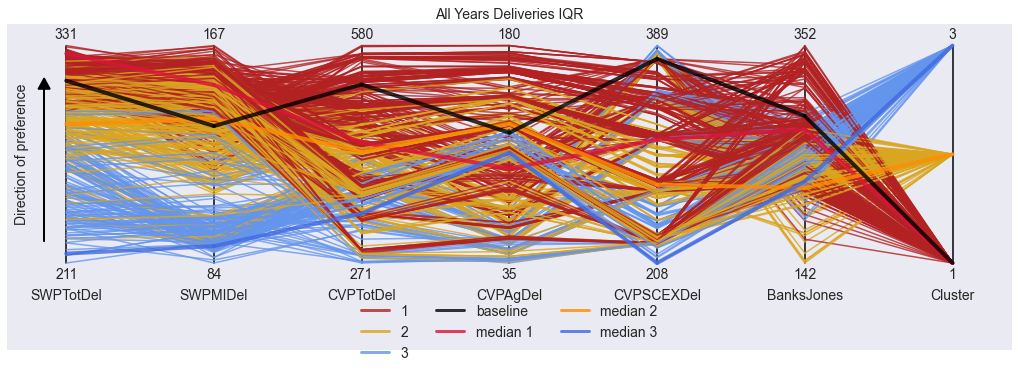

In [62]:
custom_parallel_coordinates_highlight_cluster(df_iqr_del, columns_axes=df_iqr_del.columns,
                                                axis_labels=df_iqr_del.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical,
                                                save_fig_filename=f'{fig_dir}/df_iqr_del_all.png',
                                                title="All Years Deliveries IQR",
                                                highlight_indices=all_medoids, highlight_colors=median_colors)

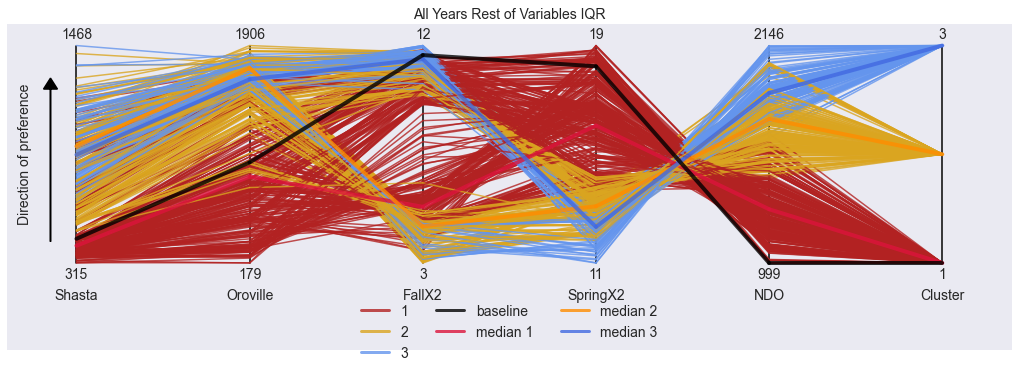

In [63]:
custom_parallel_coordinates_highlight_cluster(df_iqr_rest, columns_axes=df_iqr_rest.columns,
                                                axis_labels=df_iqr_rest.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical,
                                                save_fig_filename=f'{fig_dir}/df_iqr_rest_all.png',
                                                title="All Years Rest of Variables IQR",
                                                highlight_indices=all_medoids, highlight_colors=median_colors)

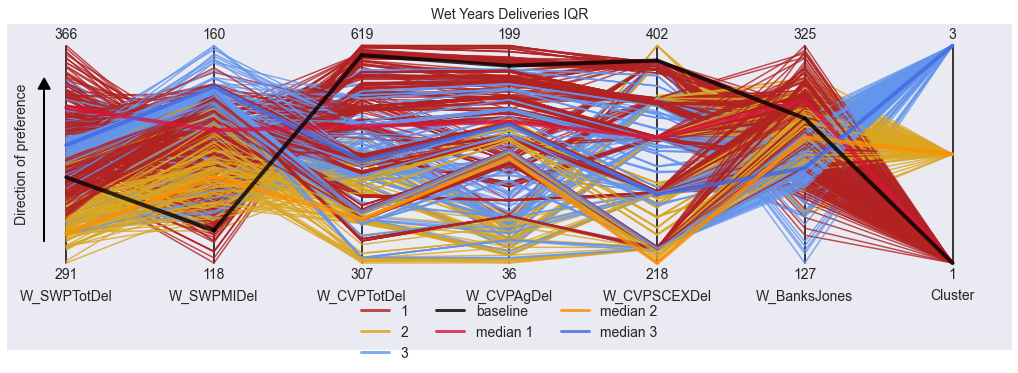

In [64]:
custom_parallel_coordinates_highlight_cluster(wet_df_iqr_del, columns_axes=wet_df_iqr_del.columns,
                                                axis_labels=wet_df_iqr_del.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical,
                                                save_fig_filename=f'{fig_dir}/wet_df_iqr_del_all.png',
                                                title="Wet Years Deliveries IQR",
                                                highlight_indices=wet_medoids, highlight_colors=median_colors)

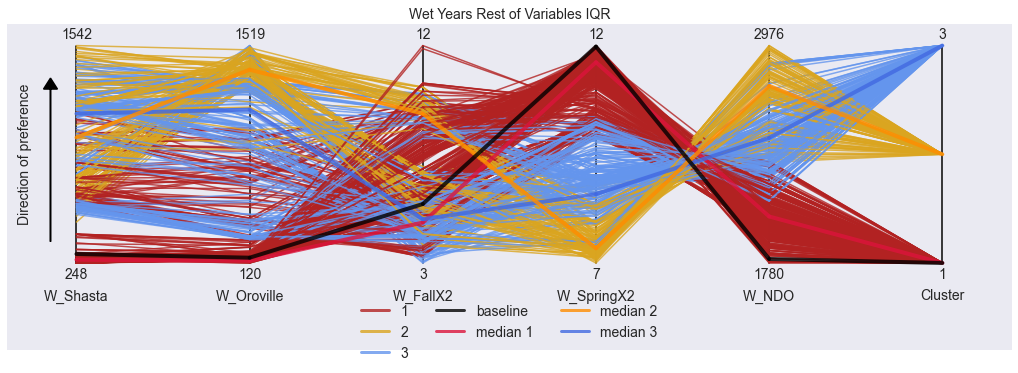

In [65]:
custom_parallel_coordinates_highlight_cluster(wet_df_iqr_rest, columns_axes=wet_df_iqr_rest.columns,
                                                axis_labels=wet_df_iqr_rest.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical,
                                                save_fig_filename=f'{fig_dir}/wet_df_iqr_rest_all.png',
                                                title="Wet Years Rest of Variables IQR",
                                                highlight_indices=wet_medoids, highlight_colors=median_colors)

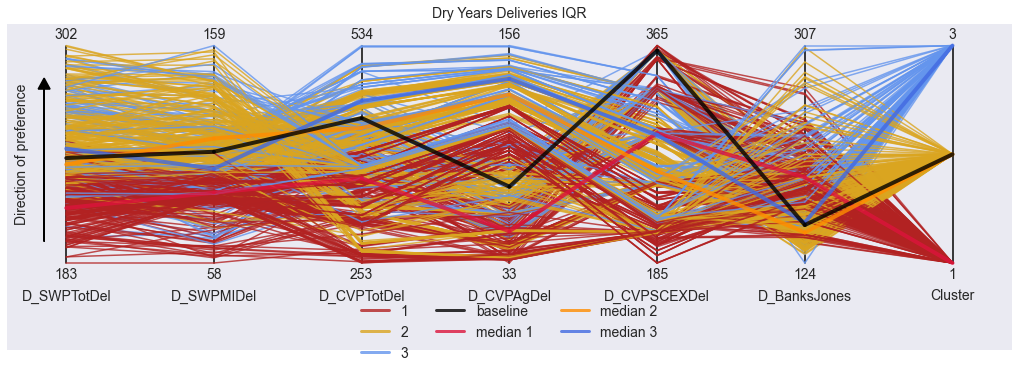

In [66]:
custom_parallel_coordinates_highlight_cluster(dry_df_iqr_del, columns_axes=dry_df_iqr_del.columns,
                                                axis_labels=dry_df_iqr_del.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical,
                                                save_fig_filename=f'{fig_dir}/dry_df_iqr_del_all.png',
                                                title="Dry Years Deliveries IQR",
                                                highlight_indices=dry_medoids, highlight_colors=median_colors)

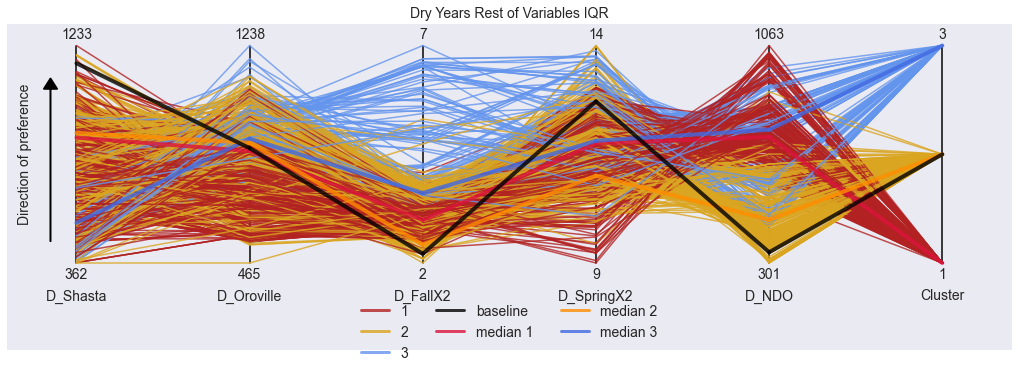

In [105]:
custom_parallel_coordinates_highlight_cluster(dry_df_iqr_rest, columns_axes=dry_df_iqr_rest.columns,
                                                axis_labels=dry_df_iqr_rest.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical,
                                                save_fig_filename=f'{fig_dir}/dry_df_iqr_rest_all.png',
                                                title="Dry Years Rest of Variables IQR",
                                                highlight_indices=dry_medoids, highlight_colors=median_colors)

##### Separate by cluster

In [67]:
df_iqr_del_cl1 = df_iqr_del[(df_iqr_del["Cluster"] == 1)].drop("Cluster", axis=1)
df_iqr_del_cl2 = df_iqr_del[(df_iqr_del["Cluster"] == 2)].drop("Cluster", axis=1)
df_iqr_del_cl3 = df_iqr_del[(df_iqr_del["Cluster"] == 3)].drop("Cluster", axis=1)

df_iqr_rest_cl1 = df_iqr_rest[(df_iqr_rest["Cluster"] == 1)].drop("Cluster", axis=1)
df_iqr_rest_cl2 = df_iqr_rest[(df_iqr_rest["Cluster"] == 2)].drop("Cluster", axis=1)
df_iqr_rest_cl3 = df_iqr_rest[(df_iqr_rest["Cluster"] == 3)].drop("Cluster", axis=1)

wet_df_iqr_del_cl1 = wet_df_iqr_del[(wet_df_iqr_del["Cluster"] == 1)].drop("Cluster", axis=1)
wet_df_iqr_del_cl2 = wet_df_iqr_del[(wet_df_iqr_del["Cluster"] == 2)].drop("Cluster", axis=1)
wet_df_iqr_del_cl3 = wet_df_iqr_del[(wet_df_iqr_del["Cluster"] == 3)].drop("Cluster", axis=1)

wet_df_iqr_rest_cl1 = wet_df_iqr_rest[(wet_df_iqr_rest["Cluster"] == 1)].drop("Cluster", axis=1)
wet_df_iqr_rest_cl2 = wet_df_iqr_rest[(wet_df_iqr_rest["Cluster"] == 2)].drop("Cluster", axis=1)
wet_df_iqr_rest_cl3 = wet_df_iqr_rest[(wet_df_iqr_rest["Cluster"] == 3)].drop("Cluster", axis=1)

dry_df_iqr_del_cl1 = dry_df_iqr_del[(dry_df_iqr_del["Cluster"] == 1)].drop("Cluster", axis=1)
dry_df_iqr_del_cl2 = dry_df_iqr_del[(dry_df_iqr_del["Cluster"] == 2)].drop("Cluster", axis=1)
dry_df_iqr_del_cl3 = dry_df_iqr_del[(dry_df_iqr_del["Cluster"] == 3)].drop("Cluster", axis=1)

dry_df_iqr_rest_cl1 = dry_df_iqr_rest[(dry_df_iqr_rest["Cluster"] == 1)].drop("Cluster", axis=1)
dry_df_iqr_rest_cl2 = dry_df_iqr_rest[(dry_df_iqr_rest["Cluster"] == 2)].drop("Cluster", axis=1)
dry_df_iqr_rest_cl3 = dry_df_iqr_rest[(dry_df_iqr_rest["Cluster"] == 3)].drop("Cluster", axis=1)

##### Cluster 1

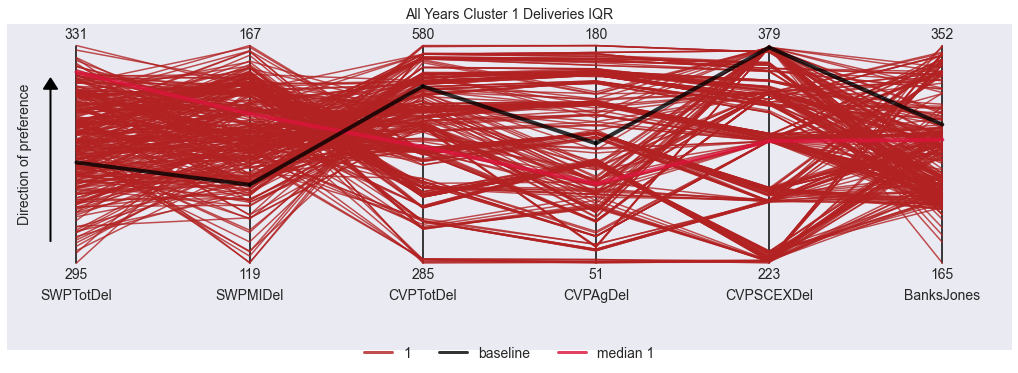

In [70]:
custom_parallel_coordinates_highlight_cluster(df_iqr_del_cl1, columns_axes=df_iqr_del_cl1.columns,
                                                axis_labels=df_iqr_del_cl1.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_1,
                                                save_fig_filename=f'{fig_dir}/df_iqr_del_cl1.png',
                                                title="All Years Cluster 1 Deliveries IQR",
                                                highlight_indices=[all_medoids[0]], highlight_colors=[median_colors[0]])

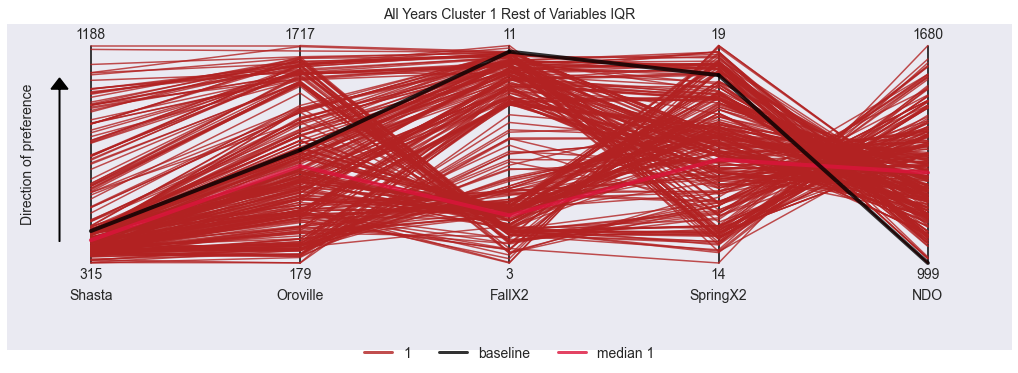

In [71]:
custom_parallel_coordinates_highlight_cluster(df_iqr_rest_cl1, columns_axes=df_iqr_rest_cl1.columns,
                                                axis_labels=df_iqr_rest_cl1.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_1,
                                                save_fig_filename=f'{fig_dir}/df_iqr_rest_cl1.png',
                                                title="All Years Cluster 1 Rest of Variables IQR",
                                                highlight_indices=[all_medoids[0]], highlight_colors=[median_colors[0]])

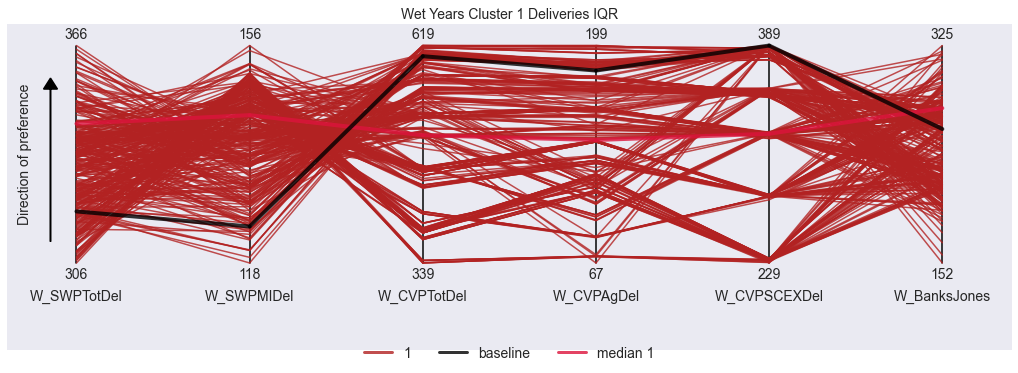

In [72]:
custom_parallel_coordinates_highlight_cluster(wet_df_iqr_del_cl1, columns_axes=wet_df_iqr_del_cl1.columns,
                                                axis_labels=wet_df_iqr_del_cl1.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_1,
                                                save_fig_filename=f'{fig_dir}/wet_df_iqr_del_cl1.png',
                                                title="Wet Years Cluster 1 Deliveries IQR",
                                                highlight_indices=[wet_medoids[0]], highlight_colors=[median_colors[0]])

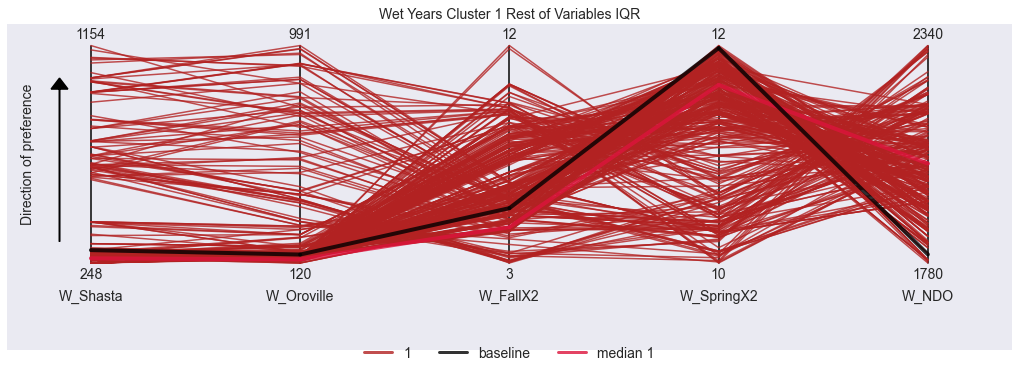

In [73]:
custom_parallel_coordinates_highlight_cluster(wet_df_iqr_rest_cl1, columns_axes=wet_df_iqr_rest_cl1.columns,
                                                axis_labels=wet_df_iqr_rest_cl1.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_1,
                                                save_fig_filename=f'{fig_dir}/wet_df_iqr_rest_cl1.png',
                                                title="Wet Years Cluster 1 Rest of Variables IQR",
                                                highlight_indices=[wet_medoids[0]], highlight_colors=[median_colors[0]])

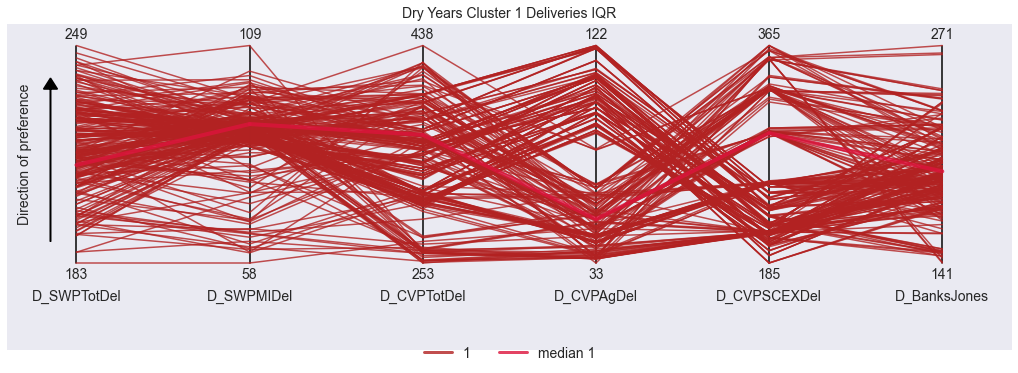

In [74]:
custom_parallel_coordinates_highlight_cluster(dry_df_iqr_del_cl1, columns_axes=dry_df_iqr_del_cl1.columns,
                                                axis_labels=dry_df_iqr_del_cl1.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_1,
                                                save_fig_filename=f'{fig_dir}/dry_df_iqr_del_cl1.png',
                                                title="Dry Years Cluster 1 Deliveries IQR",
                                                highlight_indices=[dry_medoids[0]], highlight_colors=[median_colors[0]])

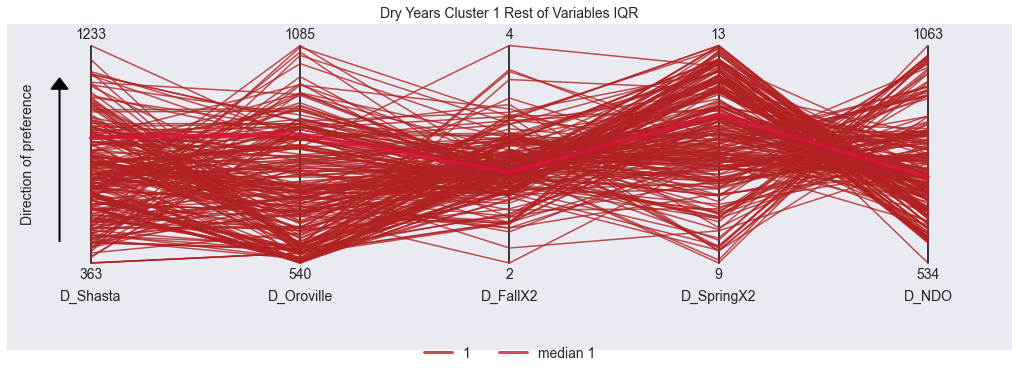

In [75]:
custom_parallel_coordinates_highlight_cluster(dry_df_iqr_rest_cl1, columns_axes=dry_df_iqr_rest_cl1.columns,
                                                axis_labels=dry_df_iqr_rest_cl1.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_1,
                                                save_fig_filename=f'{fig_dir}/dry_df_iqr_rest_cl1.png',
                                                title="Dry Years Cluster 1 Rest of Variables IQR",
                                                highlight_indices=[dry_medoids[0]], highlight_colors=[median_colors[0]])

##### Cluster 2

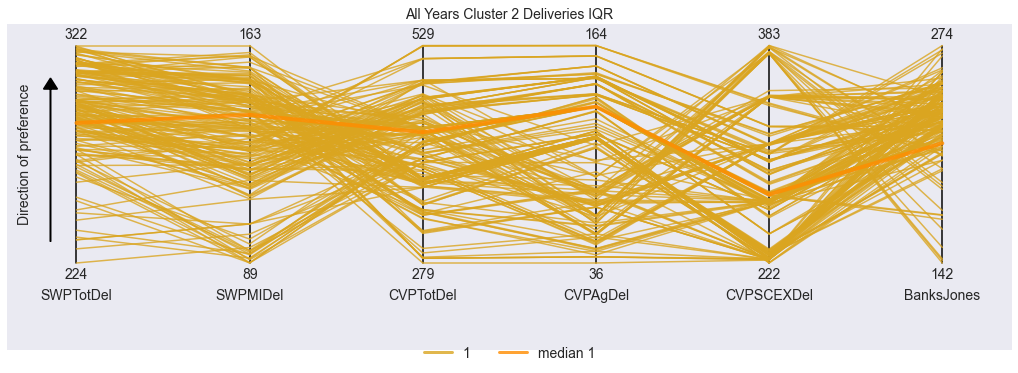

In [76]:
custom_parallel_coordinates_highlight_cluster(df_iqr_del_cl2, columns_axes=df_iqr_del_cl2.columns,
                                                axis_labels=df_iqr_del_cl2.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_2,
                                                save_fig_filename=f'{fig_dir}/df_iqr_del_cl2.png',
                                                title="All Years Cluster 2 Deliveries IQR",
                                                highlight_indices=[all_medoids[1]], highlight_colors=[median_colors[1]])

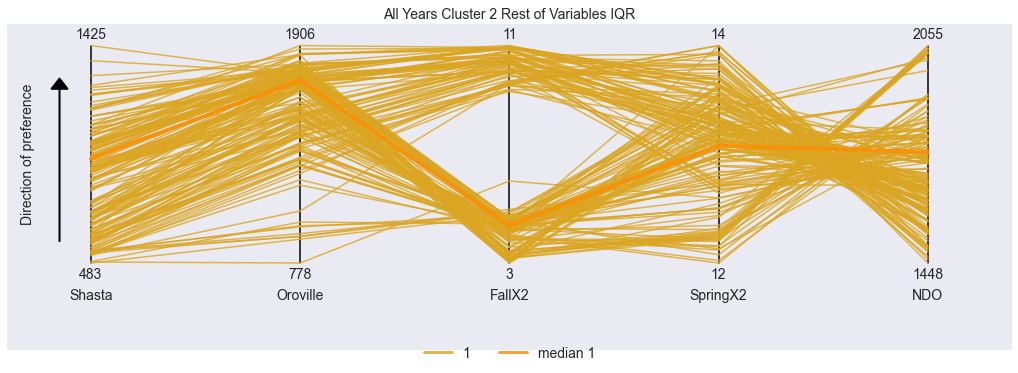

In [77]:
custom_parallel_coordinates_highlight_cluster(df_iqr_rest_cl2, columns_axes=df_iqr_rest_cl2.columns,
                                                axis_labels=df_iqr_rest_cl2.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_2,
                                                save_fig_filename=f'{fig_dir}/df_iqr_rest_cl2.png',
                                                title="All Years Cluster 2 Rest of Variables IQR",
                                                highlight_indices=[all_medoids[1]], highlight_colors=[median_colors[1]])

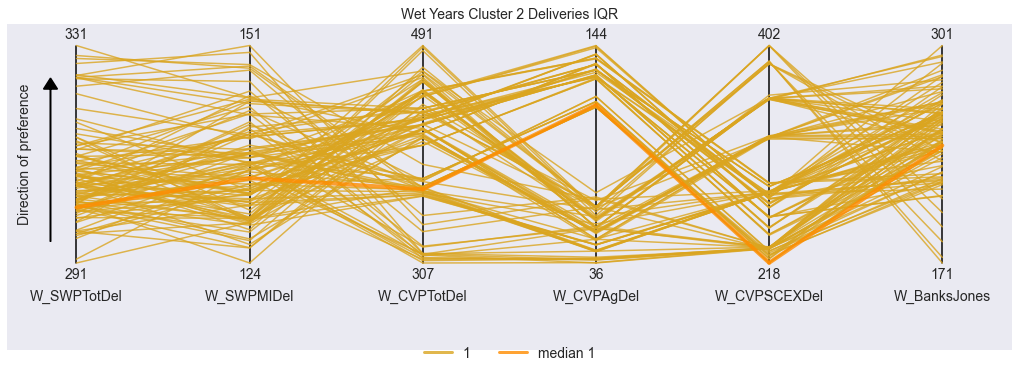

In [78]:
custom_parallel_coordinates_highlight_cluster(wet_df_iqr_del_cl2, columns_axes=wet_df_iqr_del_cl2.columns,
                                                axis_labels=wet_df_iqr_del_cl2.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_2,
                                                save_fig_filename=f'{fig_dir}/wet_df_iqr_del_cl2.png',
                                                title="Wet Years Cluster 2 Deliveries IQR",
                                                highlight_indices=[wet_medoids[1]], highlight_colors=[median_colors[1]])

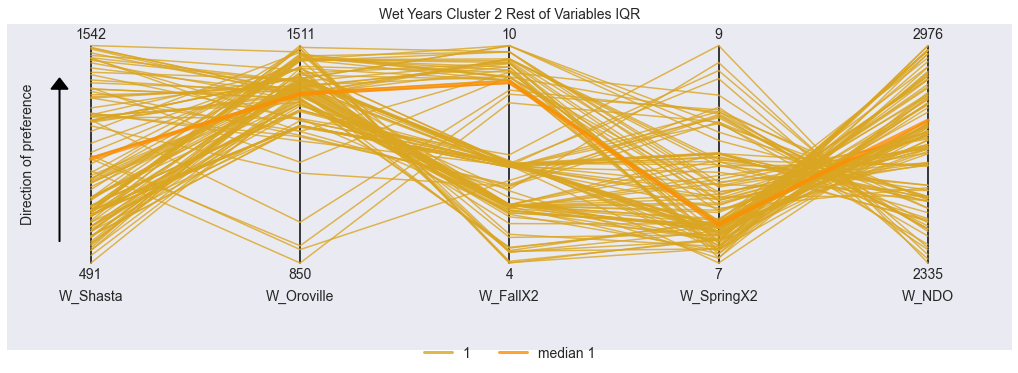

In [79]:
custom_parallel_coordinates_highlight_cluster(wet_df_iqr_rest_cl2, columns_axes=wet_df_iqr_rest_cl2.columns,
                                                axis_labels=wet_df_iqr_rest_cl2.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_2,
                                                save_fig_filename=f'{fig_dir}/wet_df_iqr_rest_cl2.png',
                                                title="Wet Years Cluster 2 Rest of Variables IQR",
                                                highlight_indices=[wet_medoids[1]], highlight_colors=[median_colors[1]])

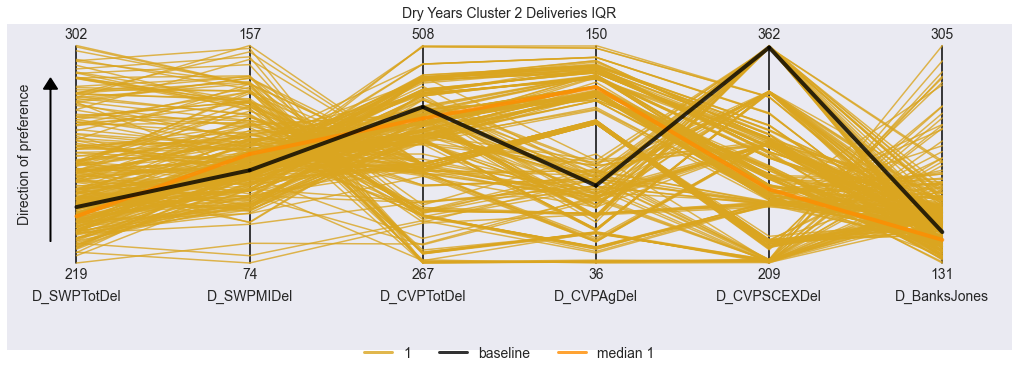

In [80]:
custom_parallel_coordinates_highlight_cluster(dry_df_iqr_del_cl2, columns_axes=dry_df_iqr_del_cl2.columns,
                                                axis_labels=dry_df_iqr_del_cl2.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_2,
                                                save_fig_filename=f'{fig_dir}/dry_df_iqr_del_cl2.png',
                                                title="Dry Years Cluster 2 Deliveries IQR",
                                                highlight_indices=[dry_medoids[1]], highlight_colors=[median_colors[1]])

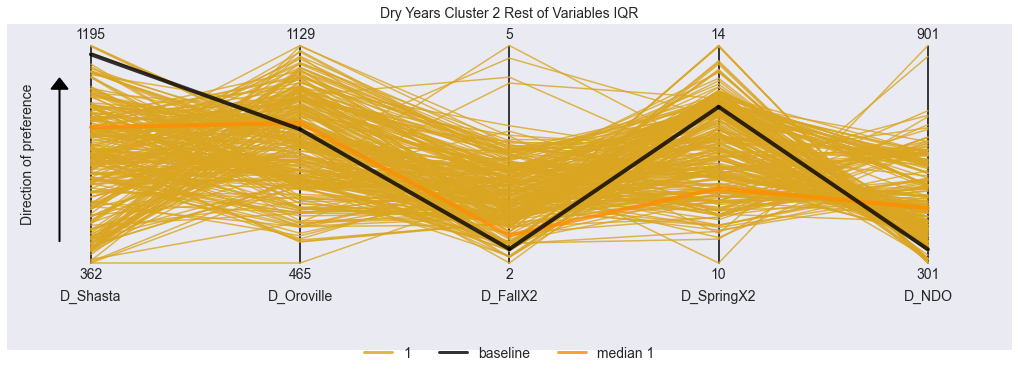

In [81]:
custom_parallel_coordinates_highlight_cluster(dry_df_iqr_rest_cl2, columns_axes=dry_df_iqr_rest_cl2.columns,
                                                axis_labels=dry_df_iqr_rest_cl2.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_2,
                                                save_fig_filename=f'{fig_dir}/dry_df_iqr_rest_cl2.png',
                                                title="Dry Years Cluster 2 Rest of Variables IQR",
                                                highlight_indices=[dry_medoids[1]], highlight_colors=[median_colors[1]])

##### Cluster 3

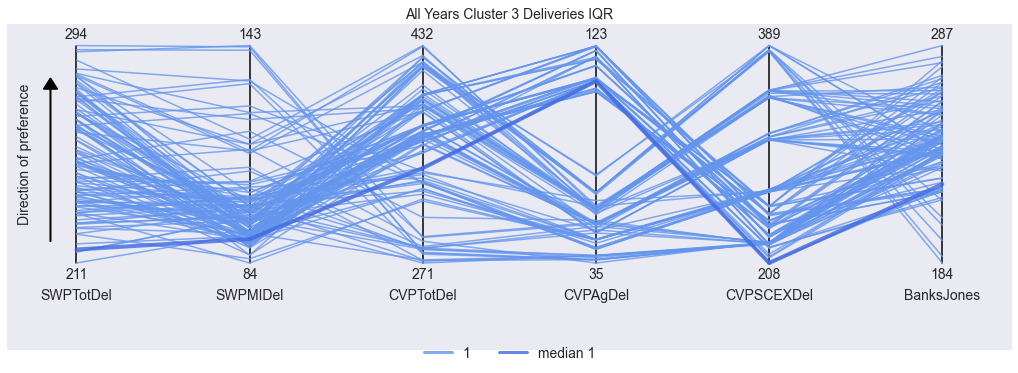

In [82]:
custom_parallel_coordinates_highlight_cluster(df_iqr_del_cl3, columns_axes=df_iqr_del_cl3.columns,
                                                axis_labels=df_iqr_del_cl3.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_3,
                                                save_fig_filename=f'{fig_dir}/df_iqr_del_cl3.png',
                                                title="All Years Cluster 3 Deliveries IQR",
                                                highlight_indices=[all_medoids[2]], highlight_colors=[median_colors[2]])

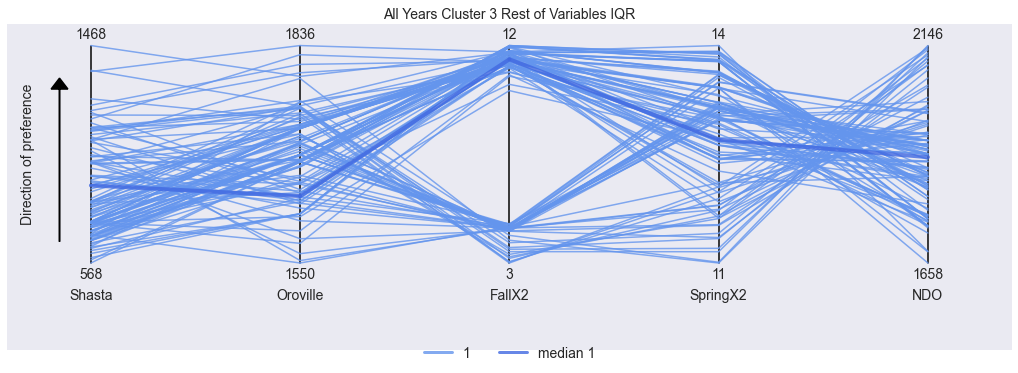

In [83]:
custom_parallel_coordinates_highlight_cluster(df_iqr_rest_cl3, columns_axes=df_iqr_rest_cl3.columns,
                                                axis_labels=df_iqr_rest_cl3.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_3,
                                                save_fig_filename=f'{fig_dir}/df_iqr_rest_cl3.png',
                                                title="All Years Cluster 3 Rest of Variables IQR",
                                                highlight_indices=[all_medoids[2]], highlight_colors=[median_colors[2]])

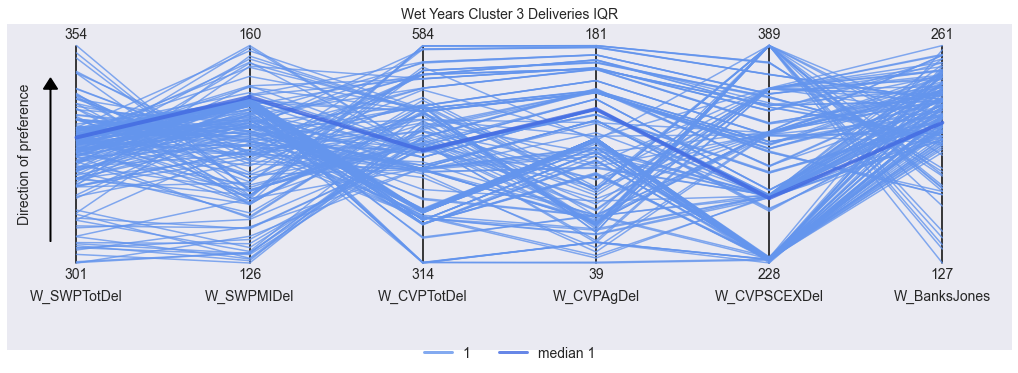

In [84]:
custom_parallel_coordinates_highlight_cluster(wet_df_iqr_del_cl3, columns_axes=wet_df_iqr_del_cl3.columns,
                                                axis_labels=wet_df_iqr_del_cl3.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_3,
                                                save_fig_filename=f'{fig_dir}/wet_df_iqr_del_cl3.png',
                                                title="Wet Years Cluster 3 Deliveries IQR",
                                                highlight_indices=[wet_medoids[2]], highlight_colors=[median_colors[2]])

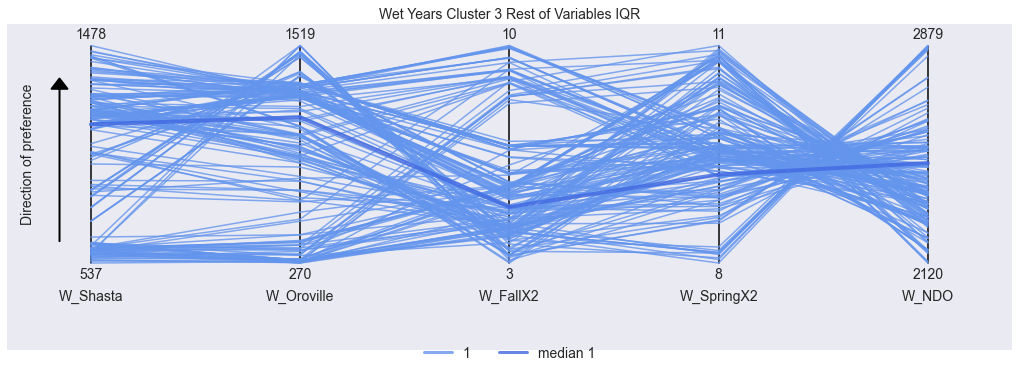

In [85]:
custom_parallel_coordinates_highlight_cluster(wet_df_iqr_rest_cl3, columns_axes=wet_df_iqr_rest_cl3.columns,
                                                axis_labels=wet_df_iqr_rest_cl3.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_3,
                                                save_fig_filename=f'{fig_dir}/wet_df_iqr_rest_cl3.png',
                                                title="Wet Years Cluster 3 Rest of Variables IQR",
                                                highlight_indices=[wet_medoids[2]], highlight_colors=[median_colors[2]])

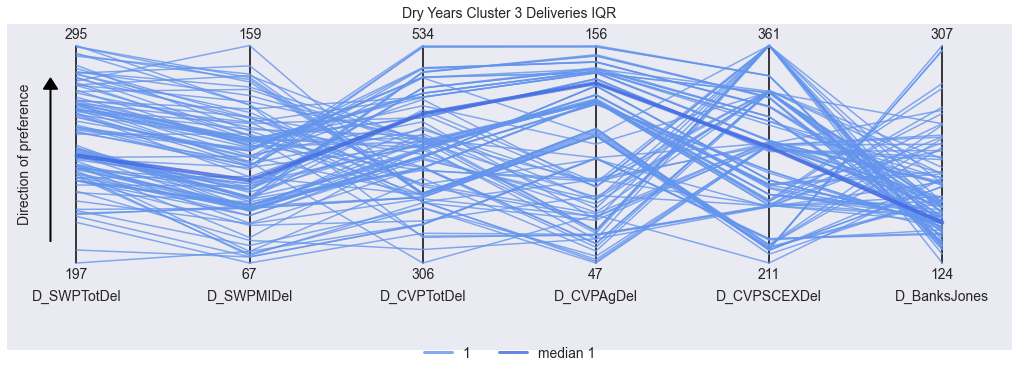

In [86]:
custom_parallel_coordinates_highlight_cluster(dry_df_iqr_del_cl3, columns_axes=dry_df_iqr_del_cl3.columns,
                                                axis_labels=dry_df_iqr_del_cl3.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_3,
                                                save_fig_filename=f'{fig_dir}/dry_df_iqr_del_cl3.png',
                                                title="Dry Years Cluster 3 Deliveries IQR",
                                                highlight_indices=[dry_medoids[2]], highlight_colors=[median_colors[2]])

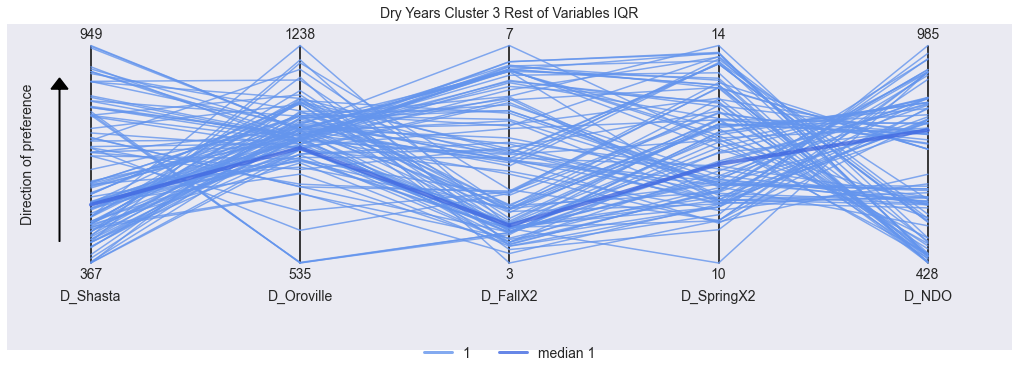

In [88]:
custom_parallel_coordinates_highlight_cluster(dry_df_iqr_rest_cl3, columns_axes=dry_df_iqr_rest_cl3.columns,
                                                axis_labels=dry_df_iqr_rest_cl3.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max', 'max', 'max', 'max', 'max'],
                                                color_by_categorical='Cluster',
                                                color_dict_categorical=color_dict_categorical_3,
                                                save_fig_filename=f'{fig_dir}/dry_df_iqr_rest_cl3.png',
                                                title="Dry Years Cluster 3 Rest of Variables IQR",
                                                highlight_indices=[dry_medoids[2]], highlight_colors=[median_colors[2]])

##### MEDOIDS + IQR

In [125]:
# knobs, equity, and unmet dropped
filtered_df = pd.read_csv(main_data_dir + "filtered_metrics_08_06_2024.csv").drop(["Unnamed: 0"], axis=1).iloc[:, 8:]
wet_filtered_df = pd.read_csv(main_data_dir + "filtered_wet_metrics_08_06_2024.csv").drop(["Unnamed: 0"], axis=1).iloc[:, 8:]
dry_filtered_df = pd.read_csv(main_data_dir + "filtered_dry_metrics_08_06_2024.csv").drop(["Unnamed: 0"], axis=1).iloc[:, 8:]

filtered_df["Cluster"] = df_clusters_new
wet_filtered_df["Cluster"] = wet_df_clusters_new
dry_filtered_df["Cluster"] = dry_df_clusters_new

In [126]:
filtered_df_del = filtered_df[["Ann_Avg_SWPTotDel_TAF", "Ann_Avg_SWPMIDel_TAF", "Ann_Avg_CVPTotDel_TAF", "Ann_Avg_CVPAgDel_TAF", "Ann_Avg_CVPSCEXDel_TAF", "Ann_Avg_BanksJones_TAF", "Cluster"]]
filtered_df_rest = filtered_df[["Apr_Avg_ShstaStorage_TAF", "Apr_Avg_OrovlStorage_TAF", "Fall_Avg_X2_KM", "Spring_Avg_X2_KM", "Ann_Avg_NDO_TAF", "Cluster"]]

wet_filtered_df_del = wet_filtered_df[["Wet_Ann_Avg_SWPTotDel_TAF", "Wet_Ann_Avg_SWPMIDel_TAF", "Wet_Ann_Avg_CVPTotDel_TAF", "Wet_Ann_Avg_CVPAgDel_TAF", "Wet_Ann_Avg_CVPSCEXDel_TAF", "Wet_Ann_Avg_BanksJones_TAF", "Cluster"]]
wet_filtered_df_rest = wet_filtered_df[["Wet_Apr_Avg_ShstaStorage_TAF", "Wet_Apr_Avg_OrovlStorage_TAF", "Wet_Fall_Avg_X2_KM", "Wet_Spring_Avg_X2_KM", "Wet_Ann_Avg_NDO_TAF", "Cluster"]]

dry_filtered_df_del = dry_filtered_df[["Dry_Ann_Avg_SWPTotDel_TAF", "Dry_Ann_Avg_SWPMIDel_TAF", "Dry_Ann_Avg_CVPTotDel_TAF", "Dry_Ann_Avg_CVPAgDel_TAF", "Dry_Ann_Avg_CVPSCEXDel_TAF", "Dry_Ann_Avg_BanksJones_TAF", "Cluster"]]
dry_filtered_df_rest = dry_filtered_df[["Dry_Apr_Avg_ShstaStorage_TAF", "Dry_Apr_Avg_OrovlStorage_TAF", "Dry_Fall_Avg_X2_KM", "Dry_Spring_Avg_X2_KM", "Dry_Ann_Avg_NDO_TAF", "Cluster"]]

filtered_df_del.columns = ["SWPTotDel", "SWPMIDel", "CVPTotDel", "CVPAgDel", "CVPSCEXDel", "BanksJones", "Cluster"]
filtered_df_rest.columns = ["Shasta", "Oroville", "FallX2", "SpringX2", "NDO", "Cluster"]

wet_filtered_df_del.columns = ["W_SWPTotDel", "W_SWPMIDel", "W_CVPTotDel", "W_CVPAgDel", "W_CVPSCEXDel", "W_BanksJones", "Cluster"]
wet_filtered_df_rest.columns = ["W_Shasta", "W_Oroville", "W_FallX2", "W_SpringX2", "W_NDO", "Cluster"]

dry_filtered_df_del.columns = ["D_SWPTotDel", "D_SWPMIDel", "D_CVPTotDel", "D_CVPAgDel", "D_CVPSCEXDel", "D_BanksJones", "Cluster"]
dry_filtered_df_rest.columns = ["D_Shasta", "D_Oroville", "D_FallX2", "D_SpringX2", "D_NDO", "Cluster"]

In [113]:
# filtered_df_del_medoids = filtered_df.iloc[all_medoids]
# filtered_df_rest_medoids = filtered_df.iloc[all_medoids]
# wet_filtered_df_del_medoids = wet_filtered_df.iloc[wet_medoids]
# wet_filtered_df_rest_medoids = wet_filtered_df.iloc[wet_medoids]
# dry_filtered_df_del_medoids = dry_filtered_df.iloc[dry_medoids]
# dry_filtered_df_rest_medoids = dry_filtered_df.iloc[dry_medoids]

In [91]:
# df_iqr_del_medoids = df_iqr_del.iloc[all_medoids]
# df_iqr_rest_medoids = df_iqr_rest.iloc[all_medoids]
# wet_df_iqr_del_medoids = wet_df_iqr_del.iloc[wet_medoids]
# wet_df_iqr_rest_medoids = wet_df_iqr_rest.iloc[wet_medoids]
# dry_df_iqr_del_medoids = dry_df_iqr_del.iloc[dry_medoids]
# dry_df_iqr_rest_medoids = dry_df_iqr_rest.iloc[dry_medoids]

In [130]:
def custom_parallel_coordinates_highlight_iqr(objs, columns_axes=None, axis_labels=None, ideal_direction='top', minmaxs=None,
                                              color_by_continuous=None, color_palette_continuous=None, color_by_categorical=None,
                                              color_palette_categorical=None, colorbar_ticks_continuous=None,
                                              color_dict_categorical=None, zorder_by=None, zorder_num_classes=10,
                                              zorder_direction='ascending', alpha_base=0.8, brushing_dict=None,
                                              alpha_brush=0.05, lw_base=1.5, fontsize=14, figsize=(11,6),
                                              save_fig_filename=None, cluster_column_name='Cluster', title=None,
                                              highlight_indices=None, highlight_colors=None,
                                              filter_indices=None, iqr_data=None):
    assert ideal_direction in ['top','bottom']
    assert zorder_direction in ['ascending', 'descending']
    if minmaxs is not None:
        for minmax in minmaxs:
            assert minmax in ['max','min']
    assert color_by_continuous is None or color_by_categorical is None
    if columns_axes is None:
        columns_axes = objs.columns
    if axis_labels is None:
        axis_labels = columns_axes

    # Filter the DataFrame by the provided indices
    if filter_indices is not None:
        objs = objs.loc[filter_indices]
        if iqr_data is not None:
            iqr_data = iqr_data.loc[filter_indices]

    fig, ax = plt.subplots(1, 1, figsize=figsize, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

    objs_reorg, tops, bottoms = reorganize_objs(objs, columns_axes, ideal_direction, minmaxs)

    if brushing_dict is not None:
        satisfice = np.zeros(objs.shape[0]) == 0.
        for col_idx, (threshold, operator) in brushing_dict.items():
            if operator == '<':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] < threshold)
            elif operator == '<=':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] <= threshold)
            elif operator == '>':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] > threshold)
            elif operator == '>=':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] >= threshold)

            threshold_norm = (threshold - bottoms[col_idx]) / (tops[col_idx] - bottoms[col_idx])
            rect = Rectangle([col_idx - 0.05, 0], 0.1, threshold_norm)
            pc = PatchCollection([rect], facecolor='grey', alpha=0.5, zorder=3)
            ax.add_collection(pc)

    # Highlight IQR shading with cluster colors, except for the last column
    for i, idx in enumerate(objs.index):
        cluster_value = objs[cluster_column_name].loc[idx]
        color = color_dict_categorical.get(cluster_value, 'lightgrey')  # Default to light grey if cluster not found

        for j, col in enumerate(columns_axes[:-1]):  # Exclude the last column (Cluster)
            iqr_bottom = objs[col].iloc[i] - (iqr_data[col].iloc[i] / 2)
            iqr_top = objs[col].iloc[i] + (iqr_data[col].iloc[i] / 2)

            # Normalize the IQR bounds
            iqr_bottom_norm = (iqr_bottom - bottoms[j]) / (tops[j] - bottoms[j])
            iqr_top_norm = (iqr_top - bottoms[j]) / (tops[j] - bottoms[j])

            rect = Rectangle([j - 0.05, iqr_bottom_norm], 0.1, iqr_top_norm - iqr_bottom_norm)
            pc = PatchCollection([rect], facecolor=color, alpha=0.3, zorder=2)
            ax.add_collection(pc)

    # Ensure baseline and highlight colors and labels
    baseline_present = 0 in objs.index
    highlight_labels = [f"median {i+1}" for i in range(len(highlight_indices))]
    highlight_colors = highlight_colors

    if baseline_present:
        highlight_indices = [0] + highlight_indices
        highlight_labels = ["baseline"] + highlight_labels
        highlight_colors = ["black"] + highlight_colors

    for i in range(objs_reorg.shape[0]):
        idx_value = objs.index[i]
        if idx_value == 0 and baseline_present:
            color = "black"
            zorder = 20  # Bring to the very front
            lw = 4  # Make line wider
            label = "baseline"
        elif idx_value in highlight_indices:
            color = highlight_colors[highlight_indices.index(idx_value)]
            zorder = 15  # Bring to the front
            lw = 4  # Make line wider
            label = highlight_labels[highlight_indices.index(idx_value)]
        elif color_by_categorical is not None and cluster_column_name in objs.columns:
            cluster_value = objs[cluster_column_name].iloc[i]
            color = color_dict_categorical.get(cluster_value, 'grey')  # Use color_dict_categorical for color
            zorder = 4
            lw = lw_base
            label = None
        else:
            color = color_dict_categorical[1]  # Fallback color if no cluster info
            zorder = 4
            lw = lw_base
            label = None

        alpha = alpha_base

        for j in range(objs_reorg.shape[1] - 1):
            y = [objs_reorg.iloc[i, j], objs_reorg.iloc[i, j + 1]]
            x = [j, j + 1]
            ax.plot(x, y, c=color, alpha=alpha, zorder=zorder, lw=lw)

    for j in range(len(columns_axes)):
        ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom', zorder=5, fontsize=fontsize)
        ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top', zorder=5, fontsize=fontsize)
        ax.plot([j, j], [0, 1], c='k', zorder=1)

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

    if ideal_direction == 'top':
        ax.arrow(-0.15, 0.1, 0, 0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    elif ideal_direction == 'bottom':
        ax.arrow(-0.15, 0.9, 0, -0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    ax.annotate('Direction of preference', xy=(-0.3, 0.5), ha='center', va='center', rotation=90, fontsize=fontsize)

    ax.set_xlim(-0.4, len(columns_axes) - 0.6)
    ax.set_ylim(-0.4, 1.1)

    for i, l in enumerate(axis_labels):
        ax.annotate(l, xy=(i, -0.12), ha='center', va='top', fontsize=fontsize)

    if color_by_continuous is not None:
        mappable = cm.ScalarMappable(cmap=color_palette_continuous)
        mappable.set_clim(vmin=objs[columns_axes[color_by_continuous]].min(),
                          vmax=objs[columns_axes[color_by_continuous]].max())
        cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,
                          label=axis_labels[color_by_continuous], pad=0.03,
                          alpha=alpha_base)
        if colorbar_ticks_continuous is not None:
            _ = cb.ax.set_xticks(colorbar_ticks_continuous, colorbar_ticks_continuous,
                                 fontsize=fontsize)
        _ = cb.ax.set_xlabel(cb.ax.get_xlabel(), fontsize=fontsize)
    elif color_by_categorical is not None or highlight_indices is not None:
        leg = []
        if color_by_categorical is not None:
            for label, color in color_dict_categorical.items():
                leg.append(Line2D([0], [0], color=color, lw=3, alpha=alpha_base, label=label))
        if highlight_indices is not None:
            for idx, color, label in zip(highlight_indices, highlight_colors, highlight_labels):
                leg.append(Line2D([0], [0], color=color, lw=3, alpha=alpha_base, label=label))

        _ = ax.legend(handles=leg, loc='lower center', ncol=max(3, len(color_dict_categorical)),
                      bbox_to_anchor=[0.5, -0.07], frameon=False, fontsize=fontsize)

    if title is not None:
        ax.set_title(title, fontsize=fontsize)

    if save_fig_filename is not None:
        plt.savefig(save_fig_filename, bbox_inches='tight', transparent=True, dpi=600)

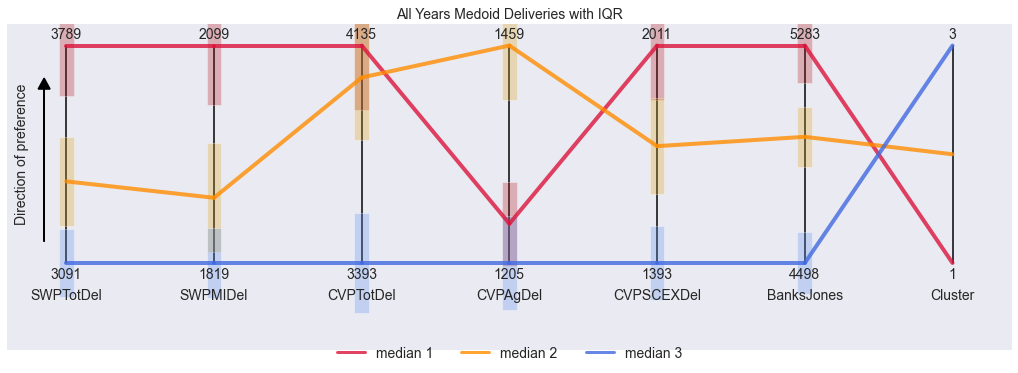

In [132]:
custom_parallel_coordinates_highlight_iqr(filtered_df_del, columns_axes=filtered_df_del.columns,
                                                axis_labels=filtered_df_del.columns,
                                                ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                color_dict_categorical=color_dict_categorical,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
                                                save_fig_filename=f'{fig_dir}/all_deliveries_medoid_with_iqr.png',
                                                title="All Years Medoid Deliveries with IQR",
                                                highlight_indices=all_medoids, highlight_colors=median_colors,
                                                filter_indices=all_medoids, iqr_data=df_iqr_del_medoids)

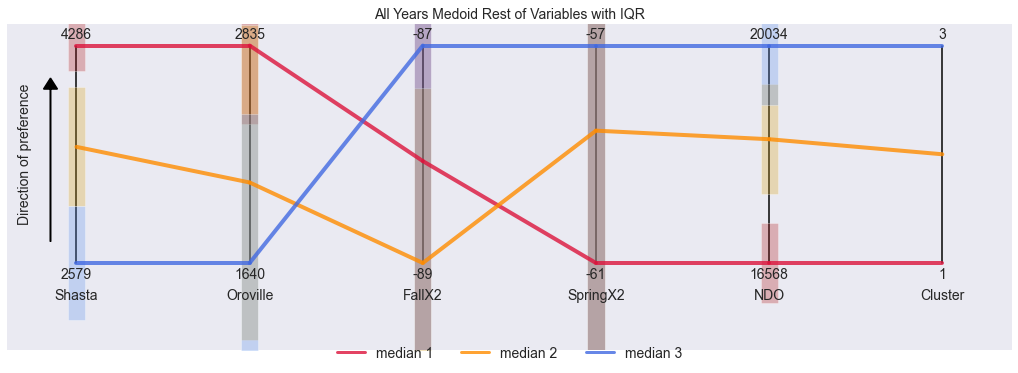

In [136]:
custom_parallel_coordinates_highlight_iqr(filtered_df_rest, columns_axes=filtered_df_rest.columns,
                                                axis_labels=filtered_df_rest.columns,
                                                ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                color_dict_categorical=color_dict_categorical,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                save_fig_filename=f'{fig_dir}/all_rest_medoid_with_iqr.png',
                                                title="All Years Medoid Rest of Variables with IQR",
                                                highlight_indices=all_medoids, highlight_colors=median_colors,
                                                filter_indices=all_medoids, iqr_data=df_iqr_rest_medoids)

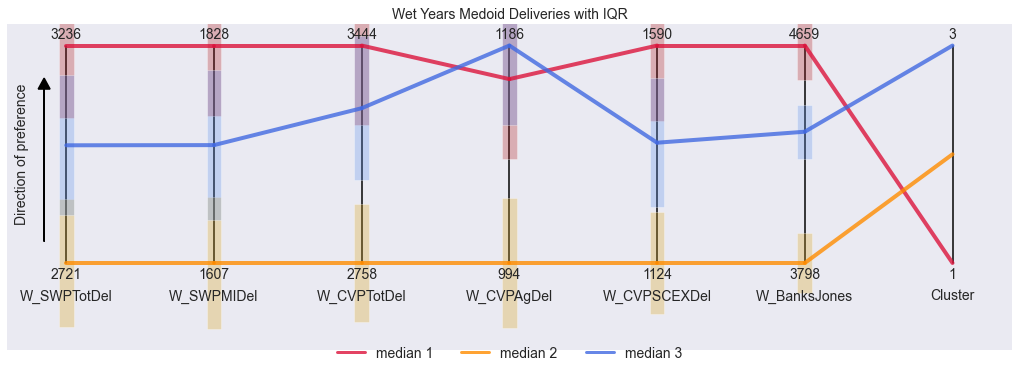

In [137]:
custom_parallel_coordinates_highlight_iqr(wet_filtered_df_del, columns_axes=wet_filtered_df_del.columns,
                                                axis_labels=wet_filtered_df_del.columns,
                                                ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                color_dict_categorical=color_dict_categorical,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
                                                save_fig_filename=f'{fig_dir}/wet_deliveries_medoid_with_iqr.png',
                                                title="Wet Years Medoid Deliveries with IQR",
                                                highlight_indices=wet_medoids, highlight_colors=median_colors,
                                                filter_indices=wet_medoids, iqr_data=wet_df_iqr_del_medoids)

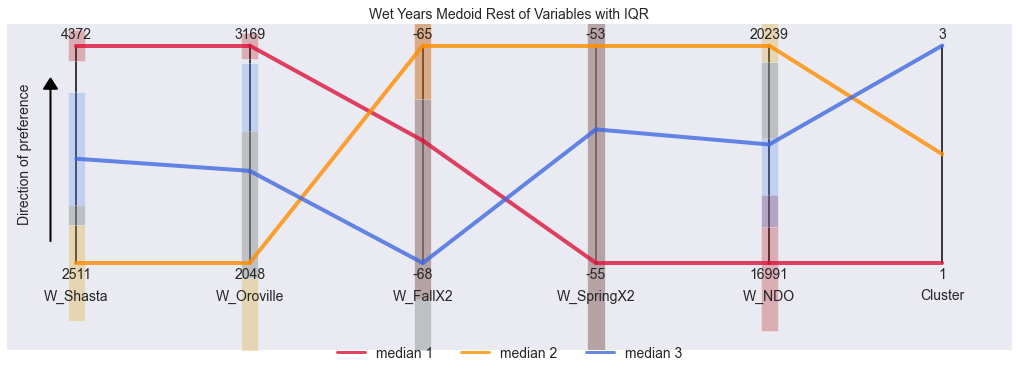

In [142]:
custom_parallel_coordinates_highlight_iqr(wet_filtered_df_rest, columns_axes=wet_filtered_df_rest.columns,
                                                axis_labels=wet_filtered_df_rest.columns,
                                                ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                color_dict_categorical=color_dict_categorical,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                save_fig_filename=f'{fig_dir}/wet_rest_medoid_with_iqr.png',
                                                title="Wet Years Medoid Rest of Variables with IQR",
                                                highlight_indices=wet_medoids, highlight_colors=median_colors,
                                                filter_indices=wet_medoids, iqr_data=wet_df_iqr_rest_medoids)

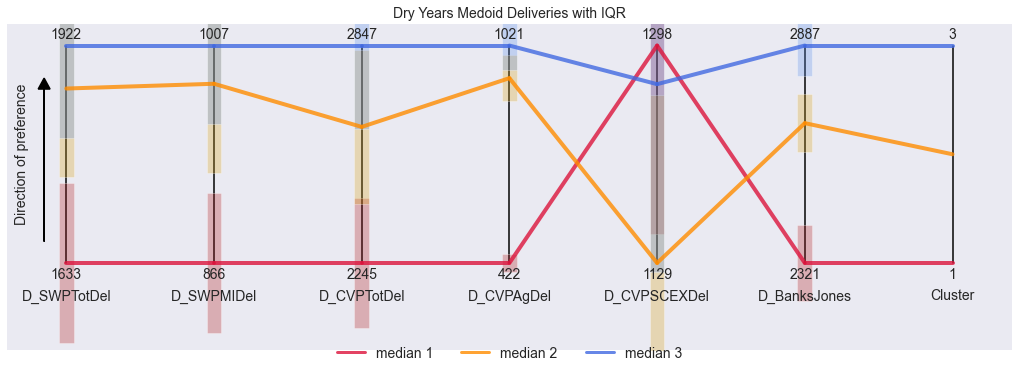

In [139]:
custom_parallel_coordinates_highlight_iqr(dry_filtered_df_del, columns_axes=dry_filtered_df_del.columns,
                                                axis_labels=dry_filtered_df_del.columns,
                                                ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                color_dict_categorical=color_dict_categorical,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max', 'max'],
                                                save_fig_filename=f'{fig_dir}/dry_deliveries_medoid_with_iqr.png',
                                                title="Dry Years Medoid Deliveries with IQR",
                                                highlight_indices=dry_medoids, highlight_colors=median_colors,
                                                filter_indices=dry_medoids, iqr_data=dry_df_iqr_del_medoids)

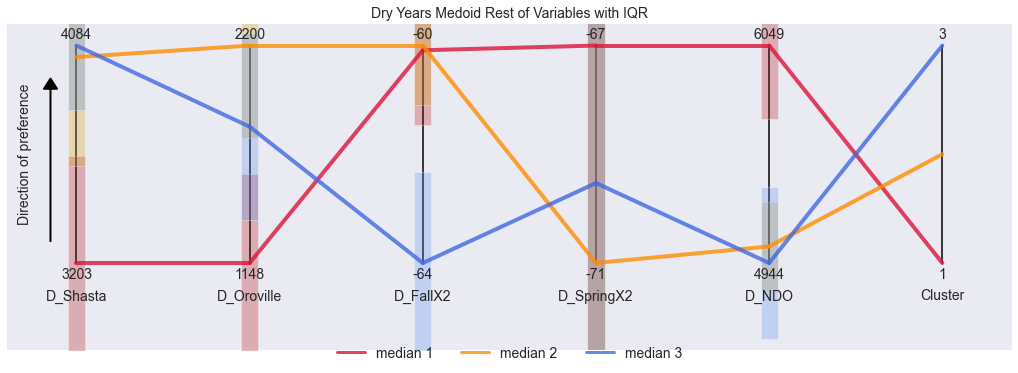

In [141]:
custom_parallel_coordinates_highlight_iqr(dry_filtered_df_rest, columns_axes=dry_filtered_df_rest.columns,
                                                axis_labels=dry_filtered_df_rest.columns,
                                                ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                color_dict_categorical=color_dict_categorical,
                                                minmaxs=['max', 'max', 'max', 'max', 'max', 'max'],
                                                save_fig_filename=f'{fig_dir}/dry_rest_medoid_with_iqr.png',
                                                title="Dry Years Medoid Rest of Variables with IQR",
                                                highlight_indices=dry_medoids, highlight_colors=median_colors,
                                                filter_indices=dry_medoids, iqr_data=dry_df_iqr_rest_medoids)

### September 3 New Metrics

In [89]:
def custom_parallel_coordinates_highlight_scenarios(objs, columns_axes=None, axis_labels=None, ideal_direction='top',
                                                  minmaxs=None, color_by_continuous=None, color_palette_continuous=None,
                                                  color_by_categorical=None, color_palette_categorical=None,
                                                  colorbar_ticks_continuous=None, color_dict_categorical=None,
                                                  zorder_by=None, zorder_num_classes=10, zorder_direction='ascending',
                                                  alpha_base=0.8, brushing_dict=None, alpha_brush=0.05, lw_base=1.5,
                                                  fontsize=14, figsize=(11,6), save_fig_filename=None,
                                                  cluster_column_name='Cluster', title=None, highlight_indices=None,
                                                  highlight_colors=None, highlight_descriptions=None):
    assert ideal_direction in ['top','bottom']
    assert zorder_direction in ['ascending', 'descending']
    if minmaxs is not None:
        for minmax in minmaxs:
            assert minmax in ['max','min']
    assert color_by_continuous is None or color_by_categorical is None
    if columns_axes is None:
        columns_axes = objs.columns
    if axis_labels is None:
        axis_labels = columns_axes

    fig, ax = plt.subplots(1, 1, figsize=figsize, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

    objs_reorg, tops, bottoms = reorganize_objs(objs, columns_axes, ideal_direction, minmaxs)

    if brushing_dict is not None:
        satisfice = np.zeros(objs.shape[0]) == 0.
        for col_idx, (threshold, operator) in brushing_dict.items():
            if operator == '<':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] < threshold)
            elif operator == '<=':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] <= threshold)
            elif operator == '>':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] > threshold)
            elif operator == '>=':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] >= threshold)

            threshold_norm = (threshold - bottoms[col_idx]) / (tops[col_idx] - bottoms[col_idx])
            rect = Rectangle([col_idx - 0.05, 0], 0.1, threshold_norm)
            pc = PatchCollection([rect], facecolor='grey', alpha=0.5, zorder=3)
            ax.add_collection(pc)

    # Ensure highlight colors and labels
    if highlight_indices is not None:
        highlight_labels = highlight_descriptions if highlight_descriptions else [f"Scenario {i+1}" for i in range(len(highlight_indices))]
        for i in range(objs_reorg.shape[0]):
            idx_value = objs.index[i]
            if idx_value in highlight_indices:
                color = highlight_colors[highlight_indices.index(idx_value)]
                zorder = 15  # Bring to the front
                lw = 4  # Make line wider
                label = highlight_labels[highlight_indices.index(idx_value)]
            elif color_by_categorical is not None and cluster_column_name in objs.columns:
                cluster_value = objs[cluster_column_name].iloc[i]
                color = color_dict_categorical.get(cluster_value, 'grey')  # Use color_dict_categorical for color
                zorder = 4
                lw = lw_base
                label = None
            else:
                color = color_dict_categorical[1]  # Fallback color if no cluster info
                zorder = 4
                lw = lw_base
                label = None

            alpha = alpha_base

            for j in range(objs_reorg.shape[1] - 1):
                y = [objs_reorg.iloc[i, j], objs_reorg.iloc[i, j + 1]]
                x = [j, j + 1]
                ax.plot(x, y, c=color, alpha=alpha, zorder=zorder, lw=lw)

    for j in range(len(columns_axes)):
        ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom', zorder=5, fontsize=fontsize)
        ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top', zorder=5, fontsize=fontsize)
        ax.plot([j, j], [0, 1], c='k', zorder=1)

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

    if ideal_direction == 'top':
        ax.arrow(-0.15, 0.1, 0, 0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    elif ideal_direction == 'bottom':
        ax.arrow(-0.15, 0.9, 0, -0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    ax.annotate('Direction of preference', xy=(-0.3, 0.5), ha='center', va='center', rotation=90, fontsize=fontsize)

    ax.set_xlim(-0.4, len(columns_axes) - 0.6)
    ax.set_ylim(-0.4, 1.1)

    for i, l in enumerate(axis_labels):
        ax.annotate(l, xy=(i, -0.12), ha='center', va='top', fontsize=fontsize)

    if color_by_continuous is not None:
        mappable = cm.ScalarMappable(cmap=color_palette_continuous)
        mappable.set_clim(vmin=objs[columns_axes[color_by_continuous]].min(),
                          vmax=objs[columns_axes[color_by_continuous]].max())
        cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,
                          label=axis_labels[color_by_continuous], pad=0.03,
                          alpha=alpha_base)
        if colorbar_ticks_continuous is not None:
            _ = cb.ax.set_xticks(colorbar_ticks_continuous, colorbar_ticks_continuous,
                                 fontsize=fontsize)
        _ = cb.ax.set_xlabel(cb.ax.get_xlabel(), fontsize=fontsize)
    elif color_by_categorical is not None or highlight_indices is not None:
        leg = []
        if color_by_categorical is not None:
            for label, color in color_dict_categorical.items():
                leg.append(Line2D([0], [0], color=color, lw=3, alpha=alpha_base, label=label))
        if highlight_indices is not None:
            for idx, color, label in zip(highlight_indices, highlight_colors, highlight_labels):
                leg.append(Line2D([0], [0], color=color, lw=3, alpha=alpha_base, label=label))

        _ = ax.legend(handles=leg, loc='lower center', ncol=max(3, len(color_dict_categorical)),
                      bbox_to_anchor=[0.5, -0.07], frameon=False, fontsize=fontsize)

    if title is not None:
        ax.set_title(title, fontsize=fontsize)

    if save_fig_filename is not None:
        plt.savefig(save_fig_filename, bbox_inches='tight', transparent=True, dpi=600)

In [68]:
# Load the new metrics
new_metrics = pd.read_csv(data_dir_knobs + "20240829DRAFT_ALL_AggFlowDel_ANNUAL_AVGS.csv").drop(["Unnamed: 0"], axis=1).iloc[:, 5:]
new_metrics

NDO_TAF  X2_APR_KM  X2_OCT_KM    SAC_IN_TAF   SJR_IN_TAF  \
0    15444.359413  64.354169  85.800450  15674.200294  3167.808035   
1    15791.146429  63.636306  85.849606  15585.867328  3402.523009   
2    16972.353047  61.211326  86.085952  15615.190402  4150.036220   
3    18013.610046  59.766159  86.260211  15852.266719  4536.439081   
4    19001.731974  58.572146  86.152293  16259.566858  4878.107334   
..            ...        ...        ...           ...          ...   
595  16915.920175  63.358152  86.587208  16261.014516  3714.665577   
596  17339.871144  62.041257  86.862864  16198.608637  3778.507538   
597  18100.624425  59.633302  89.017545  16148.850496  4261.126551   
598  18769.084019  58.217148  91.257742  16207.750072  4616.682198   
599  19660.051584  57.057232  93.645466  16377.079668  4935.875328   

     ES_YBP_IN_TAF  TOTAL_DELTA_IN_TAF  CVP_SWP_EXPORTS_TAF  \
0      3072.892998        21914.901399          5314.476603   
1      3180.183033        22168.573439          5221.053145   
2      3397.181432        23162.408101          5033.517203   
3      3472.420194        23861.125961          4691.975179   
4      3407.859726        24545.533905          4390.248056   
..             ...                 ...                  ...   
595    3400.891335        23376.571416          5732.789350   
596    3498.671855        23475.788029          5408.158154   
597    3662.663966        24072.641041          5244.092720   
598    3722.654931        24547.087198          5049.952575   
599    3775.303860        25088.258837          4700.188838   

     OTHER_EXPORTS_TAF  ADJ_CVP_SWP_EXPORTS_TAF  ...  DEL_NOD_MI_TOTAL_TAF  \
0           246.615840              5288.658351  ...            167.242596   
1           246.924352              5190.165303  ...            168.173017   
2           247.088323              5004.441202  ...            151.958584   
3           246.348147              4666.936999  ...            122.309104   
4           245.379613              4377.742706  ...             96.466023   
..                 ...                      ...  ...                   ...   
595         245.797930              5602.356526  ...            184.822331   
596         245.694789              5224.904431  ...            185.166161   
597         245.859892              4992.659958  ...            178.578193   
598         245.986605              4740.157606  ...            169.447892   
599         245.954471              4313.649134  ...            152.379516   

     DEL_SJV_AG_TOTAL_TAF  DEL_SJV_MI_TOTAL_TAF  DEL_SJV_TOTAL_TAF  \
0             2630.300276            211.659580        2841.959858   
1             2812.454504            220.018552        3032.473055   
2             2667.160731            214.080914        2881.241656   
3             2275.760549            197.171621        2472.932171   
4             1943.297861            183.918597        2127.216459   
..                    ...                   ...                ...   
595           2308.676802            257.497146        2566.173950   
596           2319.434208            258.818545        2578.252750   
597           2298.347465            255.284352        2553.631816   
598           2259.987404            248.998635        2508.986042   
599           2184.069412            238.135777        2422.205187   

     DEL_SOCAL_MI_TOTAL_TAF  DEL_CCOAST_MI_TOTAL_TAF  STO_NOD_TOTAL_APR_TAF  \
0               1663.611950                43.058307            9478.750318   
1               1713.159451                44.142288            9395.367261   
2               1705.687472                44.188684            8038.145705   
3               1717.522120                43.803496            6402.984702   
4               1698.059525                42.489390            4469.111385   
..                      ...                      ...                    ...   
595             2097.365373                54.397483           10234.135488   
59

In [69]:
new_metrics["Cluster"] = df_clusters_new

In [85]:
new_metrics_g1 = new_metrics[["DEL_NOD_AG_TOTAL_TAF", "DEL_SJV_AG_TOTAL_TAF", "DEL_NOD_MI_TOTAL_TAF", "DEL_SJV_MI_TOTAL_TAF", "DEL_SOCAL_MI_TOTAL_TAF", "CVP_SWP_EXPORTS_TAF"]]
# "DEL_SOCAL_AG_TOTAL_TAF"
new_metrics_g1

DEL_NOD_AG_TOTAL_TAF  DEL_SJV_AG_TOTAL_TAF  DEL_NOD_MI_TOTAL_TAF  \
0             3102.233973           2630.300276            167.242596   
1             3093.046688           2812.454504            168.173017   
2             2964.360670           2667.160731            151.958584   
3             2782.747861           2275.760549            122.309104   
4             2588.576134           1943.297861             96.466023   
..                    ...                   ...                   ...   
595           2133.729743           2308.676802            184.822331   
596           2135.550437           2319.434208            185.166161   
597           2122.118927           2298.347465            178.578193   
598           2079.069511           2259.987404            169.447892   
599           1978.932783           2184.069412            152.379516   

     DEL_SJV_MI_TOTAL_TAF  DEL_SOCAL_MI_TOTAL_TAF  CVP_SWP_EXPORTS_TAF  
0              211.659580             1663.611950          5314.476603  
1              220.018552             1713.159451          5221.053145  
2              214.080914             1705.687472          5033.517203  
3              197.171621             1717.522120          4691.975179  
4              183.918597             1698.059525          4390.248056  
..                    ...                     ...                  ...  
595            257.497146             2097.365373          5732.789350  
596            258.818545             2087.304951          5408.158154  
597            255.284352             2026.792463          5244.092720  
598            248.998635             1919.210900          5049.952575  
599            238.135777             1714.655604          4700.188838  

[600 rows x 6 columns]

In [84]:
new_metrics_g2 = new_metrics[["NDO_TAF", "SAC_IN_TAF", "SJR_IN_TAF", "X2_APR_KM", "X2_OCT_KM", "STO_NOD_TOTAL_APR_TAF", "STO_SOD_TOTAL_OCT_TAF"]]
new_metrics_g2

NDO_TAF    SAC_IN_TAF   SJR_IN_TAF  X2_APR_KM  X2_OCT_KM  \
0    15444.359413  15674.200294  3167.808035  64.354169  85.800450   
1    15791.146429  15585.867328  3402.523009  63.636306  85.849606   
2    16972.353047  15615.190402  4150.036220  61.211326  86.085952   
3    18013.610046  15852.266719  4536.439081  59.766159  86.260211   
4    19001.731974  16259.566858  4878.107334  58.572146  86.152293   
..            ...           ...          ...        ...        ...   
595  16915.920175  16261.014516  3714.665577  63.358152  86.587208   
596  17339.871144  16198.608637  3778.507538  62.041257  86.862864   
597  18100.624425  16148.850496  4261.126551  59.633302  89.017545   
598  18769.084019  16207.750072  4616.682198  58.217148  91.257742   
599  19660.051584  16377.079668  4935.875328  57.057232  93.645466   

     STO_NOD_TOTAL_APR_TAF  STO_SOD_TOTAL_OCT_TAF  
0              9478.750318            3403.112890  
1              9395.367261            2243.017018  
2              8038.145705            1262.250179  
3              6402.984702            1231.913168  
4              4469.111385            1279.473150  
..                     ...                    ...  
595           10234.135488            4870.422733  
596           10155.360020            4576.445284  
597            9357.009659            2626.135271  
598            8432.144566            2096.317663  
599            6649.751271            1958.433085  

[600 rows x 7 columns]

In [87]:
highlight_indices = [0, 4, 15, 261, 320, 360]  
highlight_descriptions = [
    "Baseline",
    "Natural Flows Priority",
    "Reduced Delta Regulation",
    "Rebalancing",
    "Prioritize Carryover",
    "Municipal Priority"
]

highlight_colors = ["yellow", "red", "blue", "green", "orange", "purple"] 

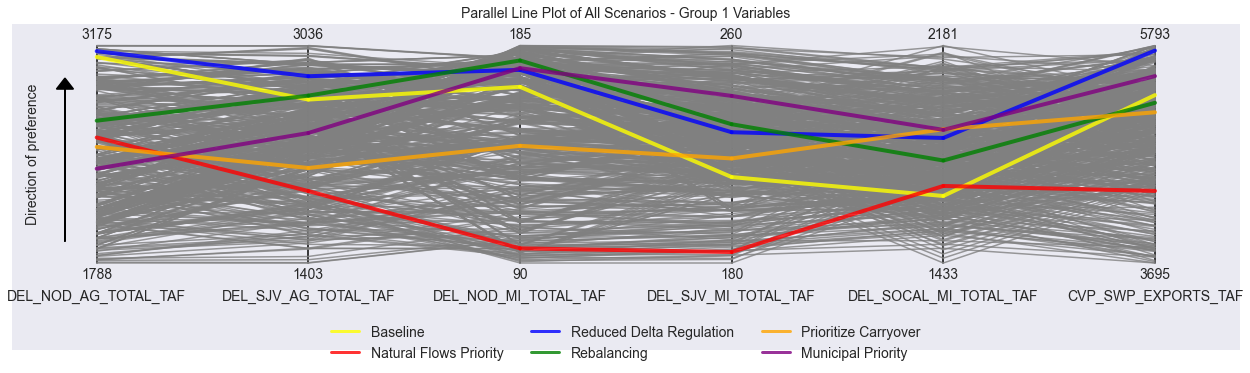

In [100]:
custom_parallel_coordinates_highlight_scenarios(
    objs=new_metrics_g1,
    columns_axes=new_metrics_g1.columns,
    axis_labels=new_metrics_g1.columns,
    ideal_direction='top',
    minmaxs=['max'] * len(new_metrics_g1.columns),
    color_dict_categorical={1: 'grey'},
    highlight_indices=highlight_indices,
    highlight_colors=highlight_colors,
    highlight_descriptions=highlight_descriptions,
    save_fig_filename="parallel_coordinates_g1.png",
    title="Parallel Line Plot of All Scenarios - Group 1 Variables",
    fontsize=14,
    figsize=(22, 6)
)

In [ ]:
custom_parallel_coordinates_highlight_scenarios(
    objs=new_metrics_g2,
    columns_axes=new_metrics_g2.columns,
    axis_labels=new_metrics_g2.columns,
    ideal_direction='top',
    minmaxs=['max'] * len(new_metrics_g2.columns),
    color_dict_categorical={1: 'grey'},
    highlight_indices=highlight_indices,
    highlight_colors=highlight_colors,
    highlight_descriptions=highlight_descriptions,
    save_fig_filename="parallel_coordinates_g2.png",
    title="Parallel Line Plot of All Scenarios - Group 2 Variables",
    fontsize=14,
    figsize=(22, 6)
)

In [ ]:
custom_parallel_coordinates_highlight_scenarios(
    objs=new_metrics_g1.iloc[highlight_indices],
    columns_axes=new_metrics_g1.columns,
    axis_labels=new_metrics_g1.columns,
    ideal_direction='top',
    minmaxs=['max'] * len(new_metrics_g1.columns),
    color_dict_categorical={1: 'grey'},
    highlight_indices=highlight_indices,
    highlight_colors=highlight_colors,
    highlight_descriptions=highlight_descriptions,
    save_fig_filename="parallel_coordinates_g1_selected.png",
    title="Parallel Line Plot of Selected Scenarios - Group 1 Variables",
    fontsize=14,
    figsize=(22, 6)
)

In [ ]:
custom_parallel_coordinates_highlight_scenarios(
    objs=new_metrics_g2.iloc[highlight_indices],
    columns_axes=new_metrics_g2.columns,
    axis_labels=new_metrics_g2.columns,
    ideal_direction='top',
    minmaxs=['max'] * len(new_metrics_g2.columns),
    color_dict_categorical={1: 'grey'},
    highlight_indices=highlight_indices,
    highlight_colors=highlight_colors,
    highlight_descriptions=highlight_descriptions,
    save_fig_filename="parallel_coordinates_g2_selected.png",
    title="Parallel Line Plot of Selected Scenarios - Group 2 Variables",
    fontsize=14,
    figsize=(22, 6)
)